<a href="https://colab.research.google.com/github/teerasitk/01205415/blob/main/TrendAndSeasonalAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# preparation

In [1]:
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Trend Analysis

## Download asset prices

In [3]:
assets = ["EURUSD=X", "GC=F", "SB=F", "WTI"]
avg = {}
maxm = {}
minm = {}
for sym in assets:
  avg[sym] = 0
for y in range(2006,2023):
  for sym in assets:
    cls_price = yf.download(sym, f"{y-1}-12-25", f"{y+1}-01-05").Close
    cls_price = cls_price.resample('1d').ffill()
    cls_price = cls_price[f"{y}"]
    cls_price /= cls_price.iloc[-1]
    cls_price -= 1.0
    if len(cls_price.values) == 365:
      avg[sym] += cls_price.values / (2023-2026 + 1)
    else:
      avg[sym] += cls_price.values[:-1] / (2023-2026 + 1)
    maxm[sym] = avg[sym].max()
    minm[sym] = avg[sym].min()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

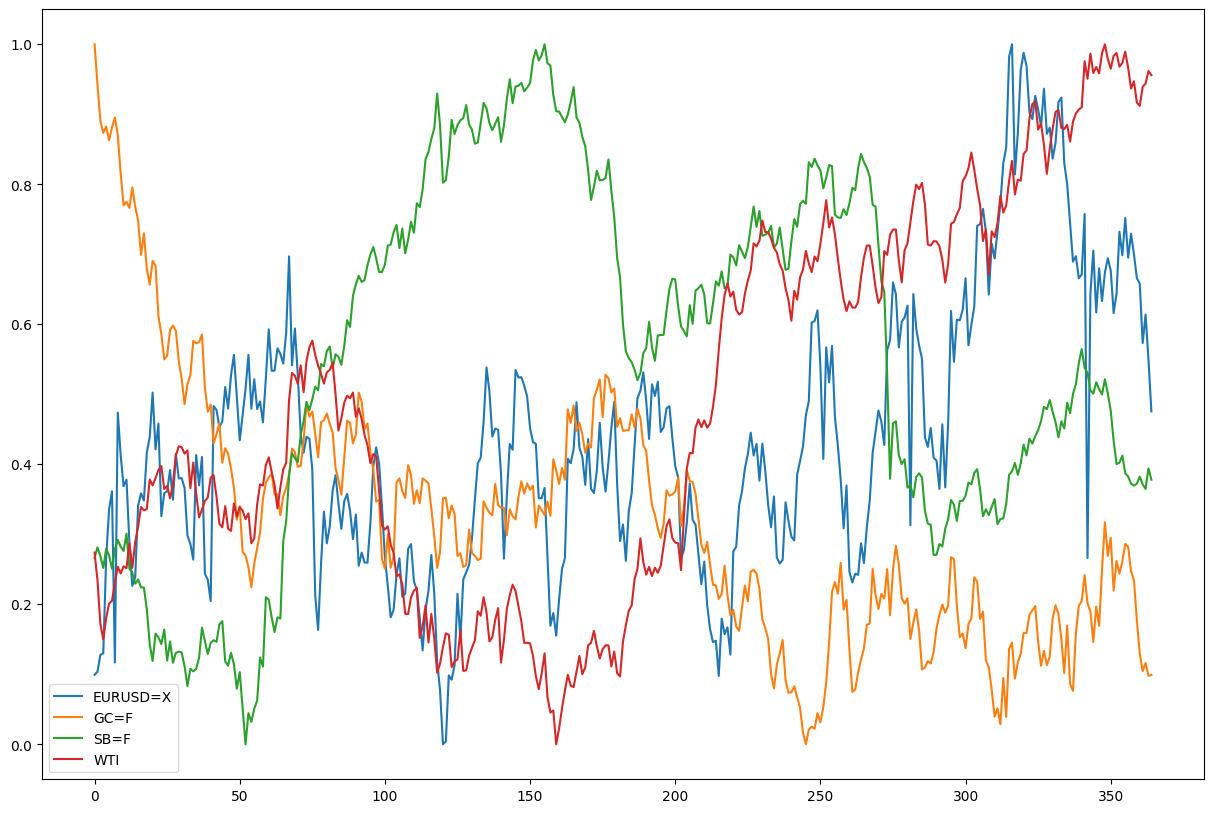

In [4]:
plt.figure(figsize=(15,10))
for sym in assets:
  dat = avg[sym] - minm[sym]
  dat = dat / (maxm[sym]- minm[sym])
  plt.plot(dat, label=sym)
plt.legend()

[*********************100%%**********************]  1 of 1 completed


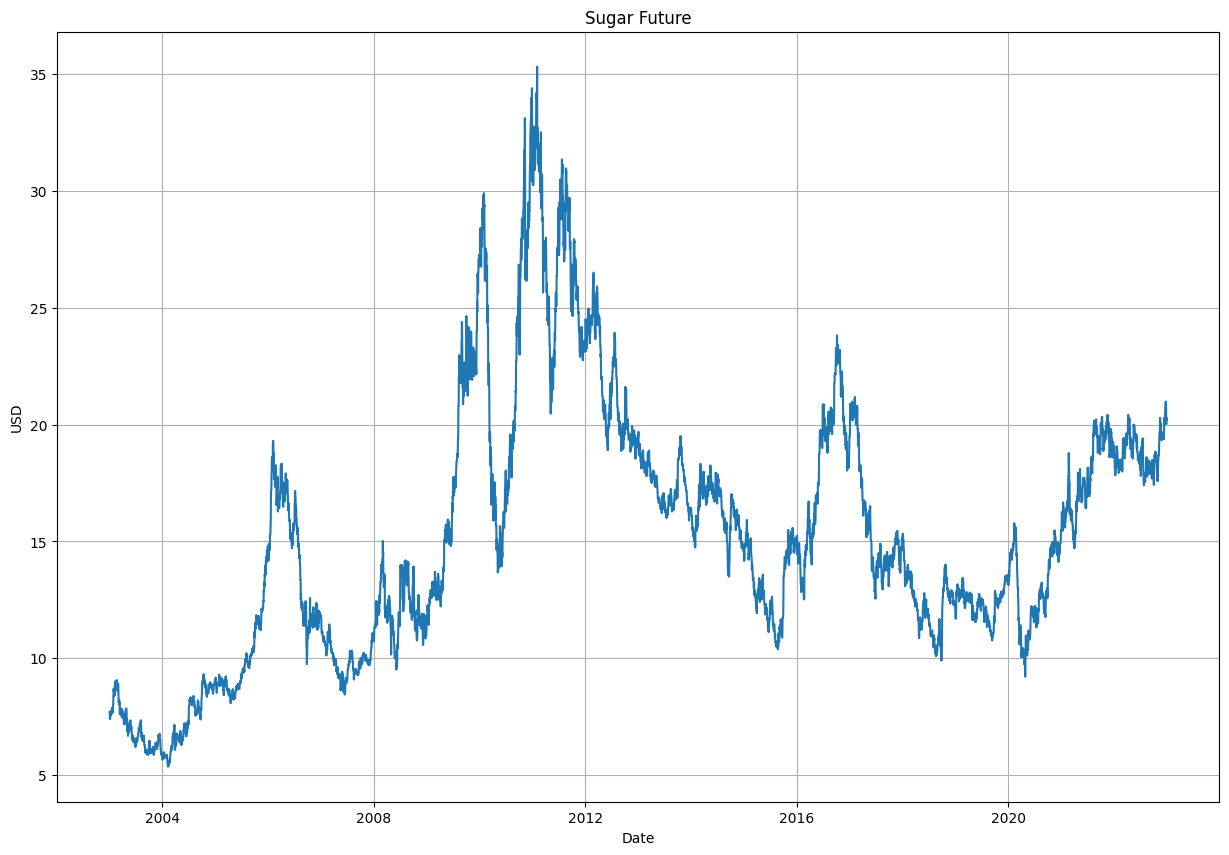

In [5]:
sugar_prices = yf.download("SB=F", "2003-01-01", "2022-12-31").Close
sugar_prices = sugar_prices.resample("1d").ffill()
plt.figure(figsize=(15,10))
plt.plot(sugar_prices)
plt.xlabel("Date")
plt.ylabel("USD")
plt.title("Sugar Future")
plt.grid()

In [6]:
log_sugar_prices = np.log(sugar_prices)
log_sugar_prices

Date
2003-01-02    2.039921
2003-01-03    2.001480
2003-01-04    2.001480
2003-01-05    2.001480
2003-01-06    2.029463
                ...   
2022-12-26    3.043570
2022-12-27    3.011606
2022-12-28    3.003700
2022-12-29    3.010128
2022-12-30    2.997730
Freq: D, Name: Close, Length: 7303, dtype: float64

In [7]:
num_data  = len(log_sugar_prices)
H = np.ones((num_data, 2))
t0 = log_sugar_prices.index[0]
t = log_sugar_prices.index - t0
H[:, 1] = t.days
print("First 5 rows of H are \n", H[:5])
a, *_  = np.linalg.lstsq(H, log_sugar_prices, rcond=1)
print("parameters are: ", a)

First 5 rows of H are 
 [[1. 0.]
 [1. 1.]
 [1. 2.]
 [1. 3.]
 [1. 4.]]
parameters are:  [2.38197888e+00 7.56719351e-05]


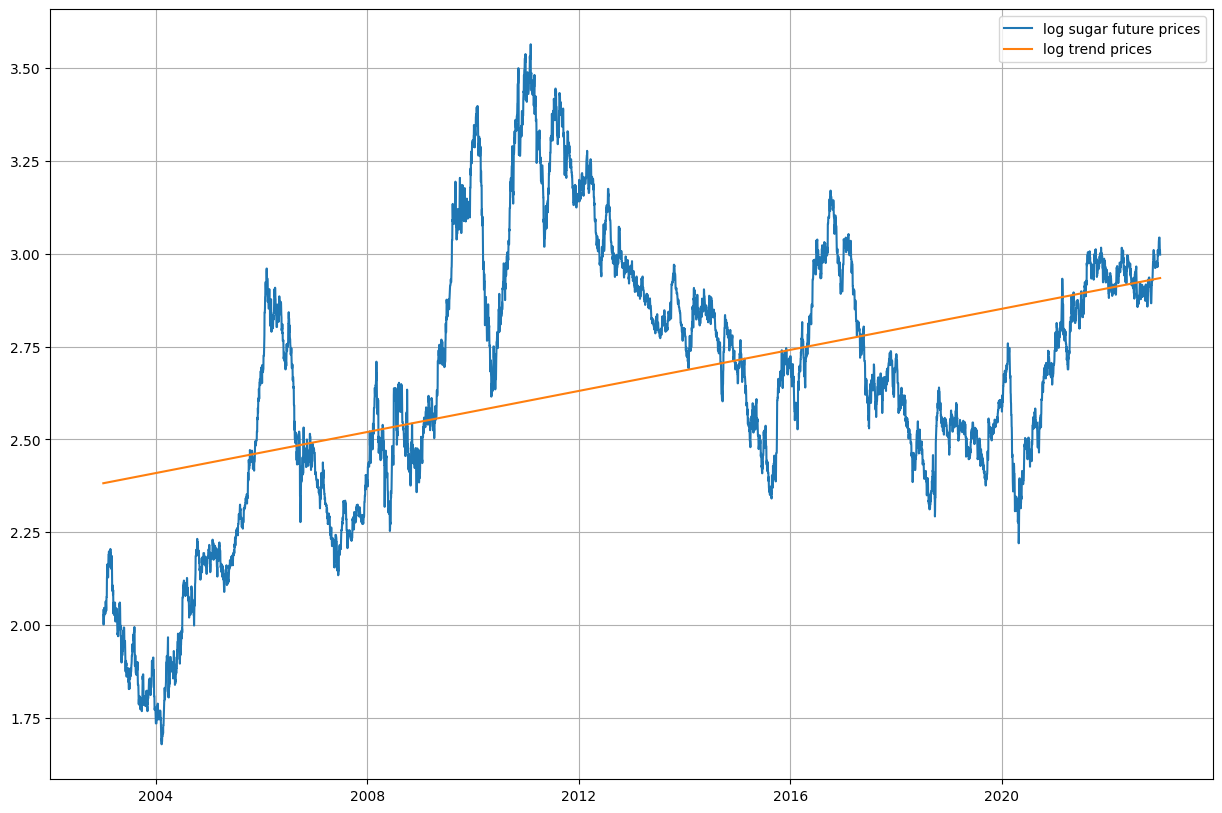

In [8]:
trend_log_prices = a[0] + a[1] * t.days
trend_log_prices = pd.Series(data=trend_log_prices, index=log_sugar_prices.index)
plt.figure(figsize=(15,10))
plt.plot(log_sugar_prices, label="log sugar future prices")
plt.plot(trend_log_prices, label="log trend prices")
plt.legend()
plt.grid()

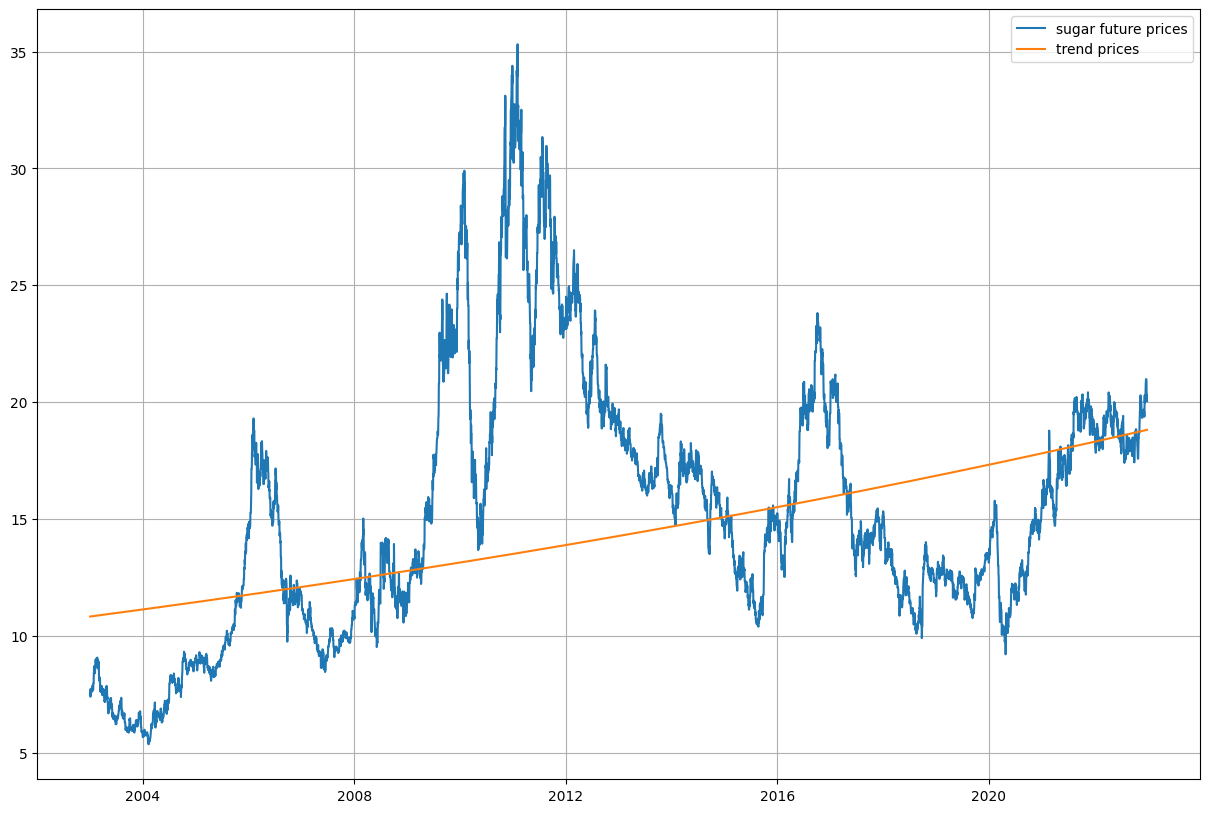

In [9]:
trend_prices = np.exp(trend_log_prices)
plt.figure(figsize=(15,10))
plt.plot(sugar_prices, label="sugar future prices")
plt.plot(trend_prices, label="trend prices")
plt.legend()
plt.grid()

## Future Trend

[*********************100%%**********************]  1 of 1 completed


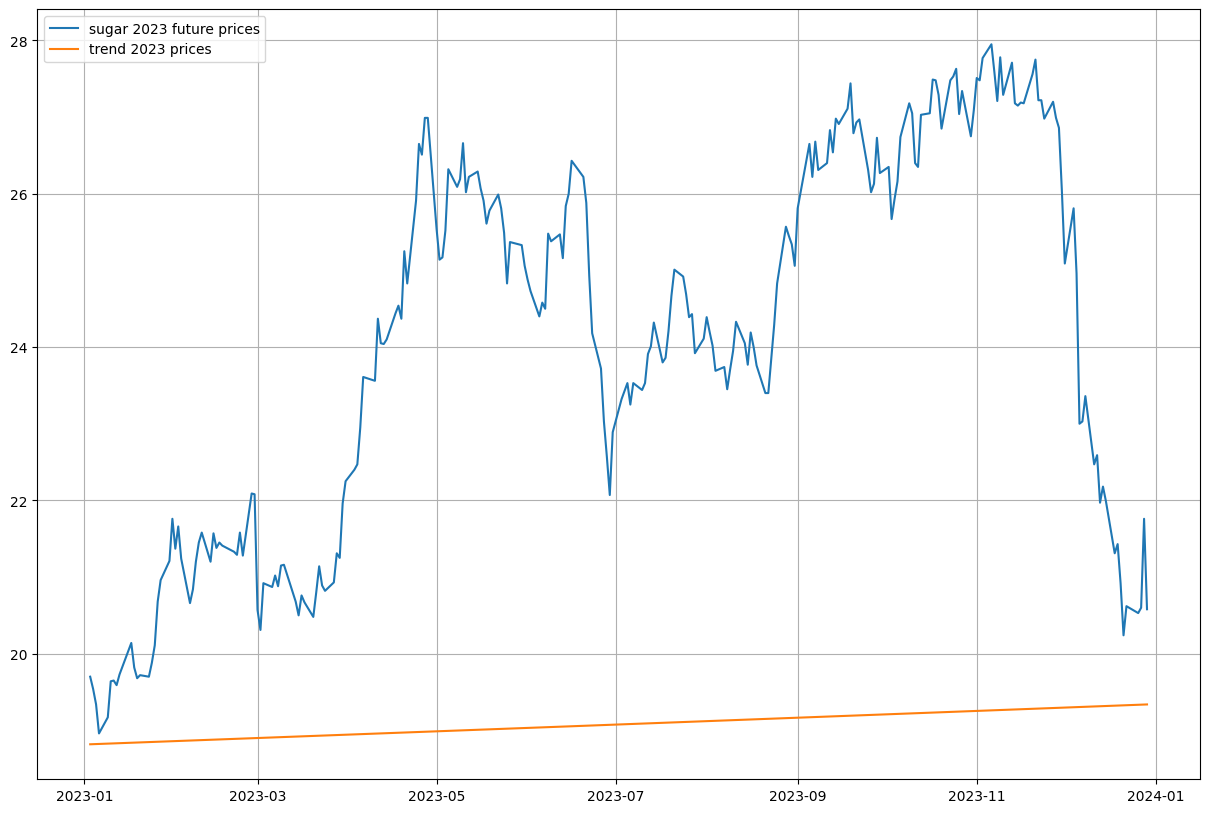

In [10]:
sugar_prices_2023 = yf.download("SB=F", "2023-01-01", "2023-12-31").Close
t_2023 = sugar_prices_2023.index - t0
log_trend_2023_price = a[0] + a[1] * t_2023.days
trend_2023_prices = pd.Series(data=np.exp(log_trend_2023_price),
                              index=sugar_prices_2023.index)

plt.figure(figsize=(15,10))
plt.plot(sugar_prices_2023, label="sugar 2023 future prices")
plt.plot(trend_2023_prices, label="trend 2023 prices")
plt.legend()
plt.grid()

# Seasonal Analysis

## Detrend data

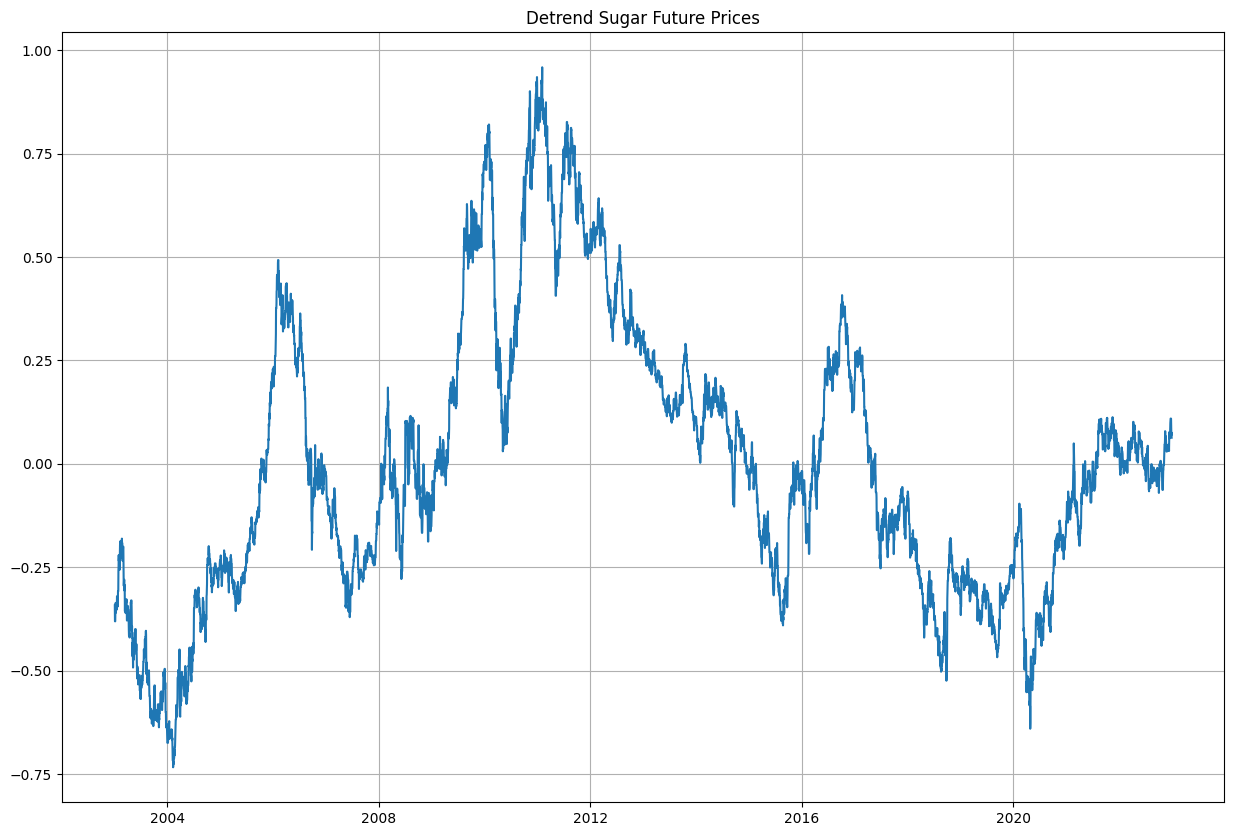

In [11]:
detrend = log_sugar_prices - trend_log_prices
plt.figure(figsize=(15,10))
plt.plot(detrend)
plt.title("Detrend Sugar Future Prices")
plt.grid()

## Harmonic Regression

In [12]:
xd = detrend # detrend data
N  = len(detrend) # number of samples
days_per_year = 365.25 # number of days in year
sample_per_day = 1 # how many sample per days
t = np.arange(N) # t=0, ..., N - 1
a0 = detrend.mean() # If trend has been properly remove
# a0 should be approximately zero.
half_N = int(N/2) # max freq = N/2
ajs, bjs, fjs = [], [], [0.0] # empyty list
if N % 2 != 0:
  for j in range(1, half_N): # for j = 1, ..., N/2
    fj = j / N # max frq = 0.5
    wj = np.pi * 2 * fj
    aj = (xd * np.cos(wj * t)).sum() # aj term
    aj = aj * (2/N)
    bj = (xd * np.sin(wj * t)).sum() # bj term
    bj = bj * (2/N)
    fjs.append(fj * sample_per_day * days_per_year) # freq to per years
    ajs.append(aj)
    bjs.append(bj)
else: # even number of samples
  aN2 = (xd * ((-1) ** t)).sum()
  fjs.append(days_per_year  * sample_per_day / 2)
  aN2 = aN2/N

## Harmonic Magnitude

In [13]:
A0 = N * a0 # a0 is the first one
mags = np.array([A0])
ajs = np.array(ajs) # change to numpy array
bjs = np.array(bjs) # change to numpy array
fjs = np.array(fjs)# change to numpy array
Aj = (N/2) * np.sqrt(ajs **2 + bjs**2) # compute each magniture
mags = np.concatenate([mags, Aj]) # concnat
if N % 2 == 0: # for even number of samples
  mags = np.append(mags, N * np.abs(aN2))

# overall Plot

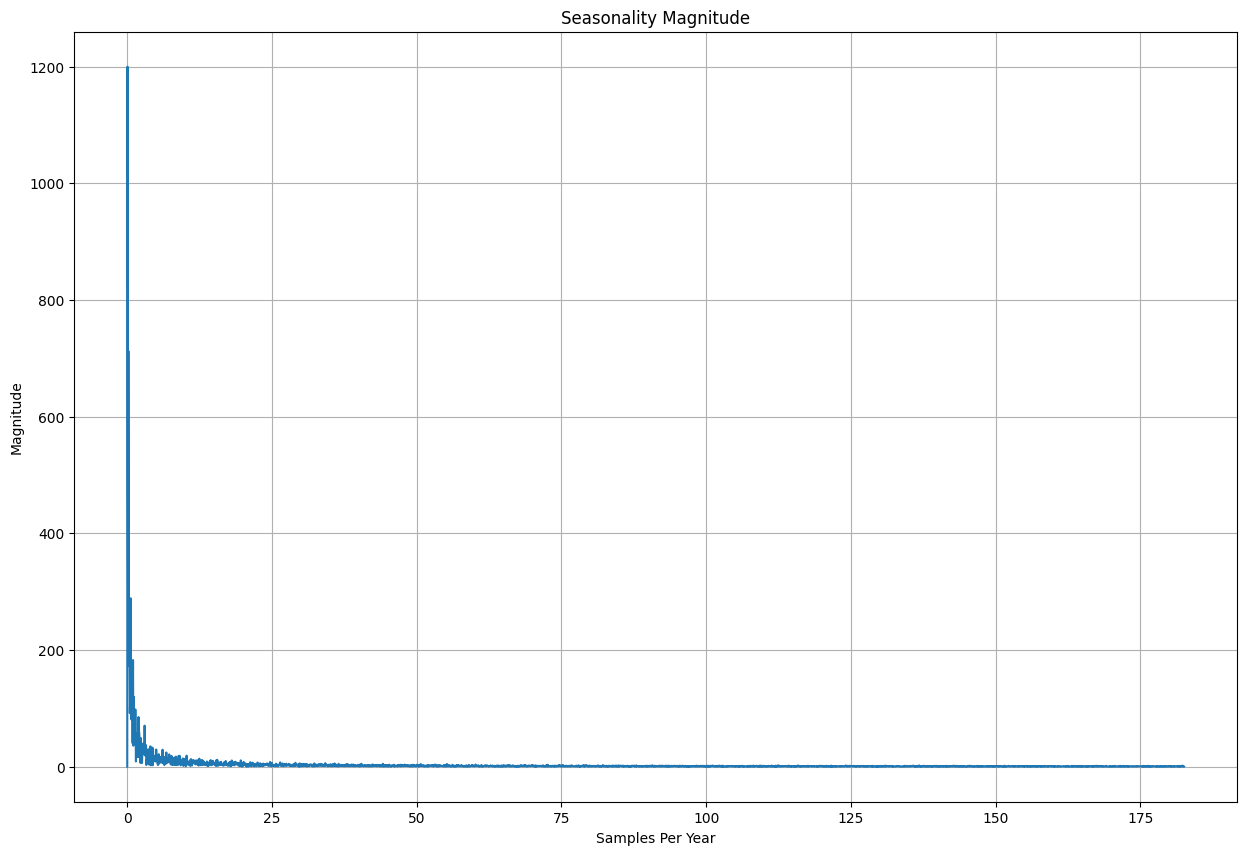

In [14]:
plt.figure(figsize=(15,10))
plt.plot(fjs, mags)
plt.xlabel("Samples Per Year")
plt.ylabel("Magnitude")
plt.title("Seasonality Magnitude")
plt.grid()


## Focus for periods of 1/2 years or more

(0.0, 2.0)

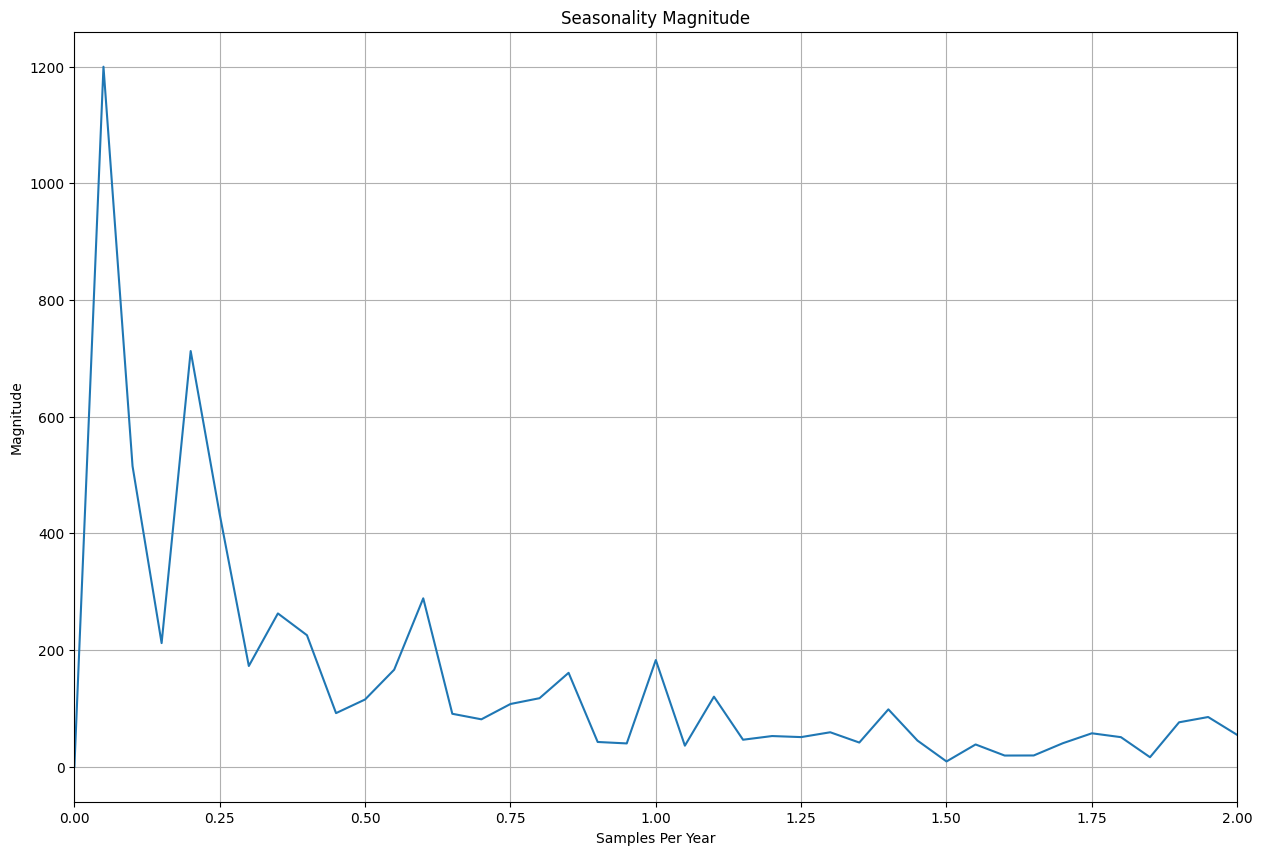

In [15]:
plt.figure(figsize=(15,10))
plt.plot(fjs, mags)
plt.xlabel("Samples Per Year")
plt.ylabel("Magnitude")
plt.title("Seasonality Magnitude")
plt.grid()
plt.xlim([0,2])

## Find Peaks

In [16]:
num_peaks = 4
sorted_args = np.argsort(mags)[::-1] # sorted from largest to smallest
fmax = fjs[sorted_args[:num_peaks]]
magmax = mags[sorted_args[:num_peaks]]
periodmax = 1.0 / fmax
print(f"Period (years):  {periodmax} years")
print(f"Magnitude:  {magmax }")

Period (years):  [19.9945243   4.99863107  9.99726215  3.99890486] years
Magnitude:  [1199.94351604  712.5338568   515.26710198  432.25798947]


## Find peaks for given ranges

In [17]:
num_peaks = 4
period_max =20 # maximum period is 3 years
period_min = 0 # minimum period is 0 years
sorted_args = np.argsort(mags)[::-1] # sorted from largest to smallest
sorted_f = fjs[sorted_args]
sorted_mag = mags[sorted_args]
sorted_period = 1.0 / sorted_f
valid_peaks = np.where(( sorted_period <= period_max) & ( sorted_period>= period_min))[0]
valid_sorted_args = sorted_args[valid_peaks]
fmax = fjs[valid_sorted_args[:num_peaks]]
magmax = mags[valid_sorted_args[:num_peaks]]
periodmax = 1.0 / fmax
print(f"Period (years):  {periodmax} years")
print(f"Magnitude:  {magmax }")

Period (years):  [19.9945243   4.99863107  9.99726215  3.99890486] years
Magnitude:  [1199.94351604  712.5338568   515.26710198  432.25798947]


<ipython-input-17-52efd83acbd5>:7: RuntimeWarning: divide by zero encountered in divide
  sorted_period = 1.0 / sorted_f


In [18]:
num_peaks = 3 # number of pearks
terms = valid_sorted_args[:num_peaks] # only valid peaks
s = 0 # initalize to zero
for j0 in terms: # for each term
  if  j0 == 0: # 0 for DC component
    s += a0
  else:
    j = j0 -1 # index in ajs and bjs
    fj = j0 / N # max frq = 0.5
    wj = np.pi * 2 * fj
    aj = ajs[j]
    bj = bjs[j]
    sj = aj * np.cos(wj * t) + bj * np.sin(wj * t) # Fourier Series
    s += sj
s = pd.Series(s, index=detrend.index)

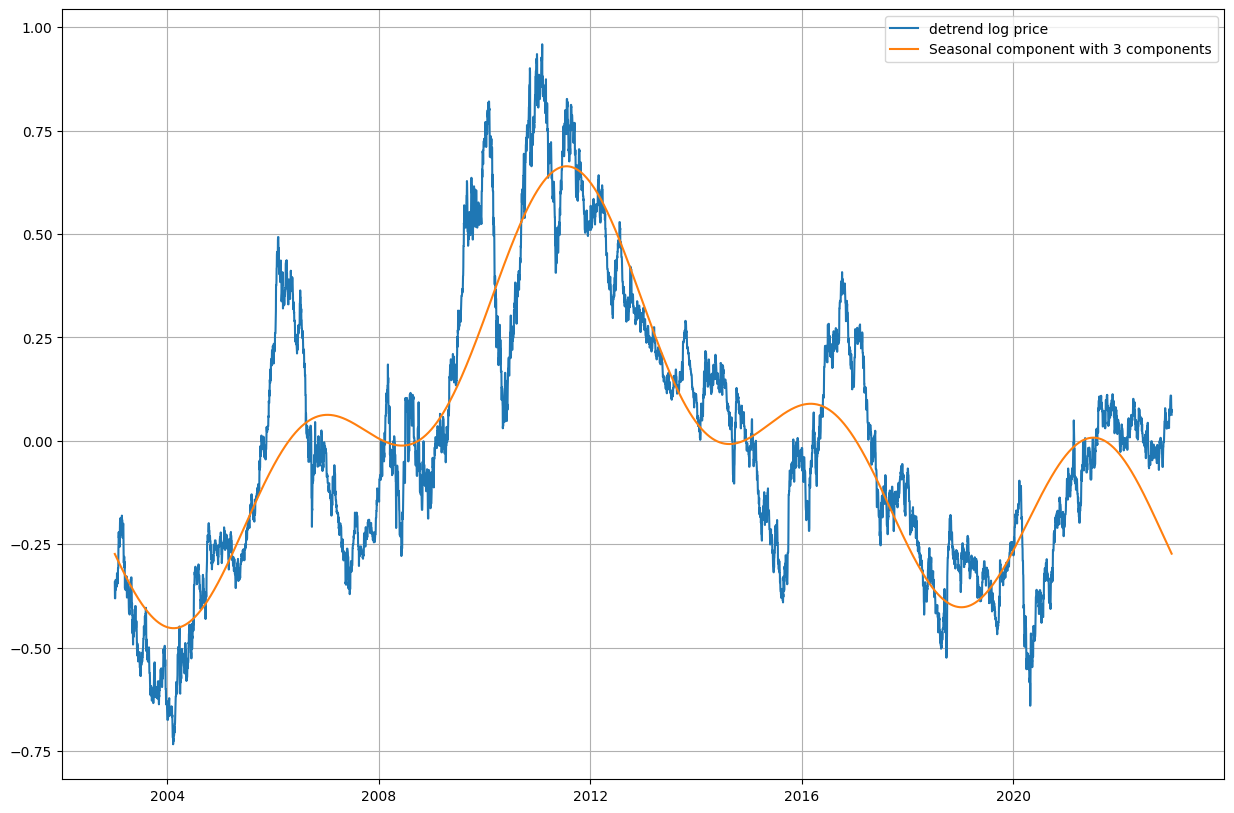

In [19]:
plt.figure(figsize=(15,10))
plt.plot(detrend, label="detrend log price")
plt.plot(s, label=f"Seasonal component with {num_peaks} components")
plt.grid()
plt.legend()

# Residue

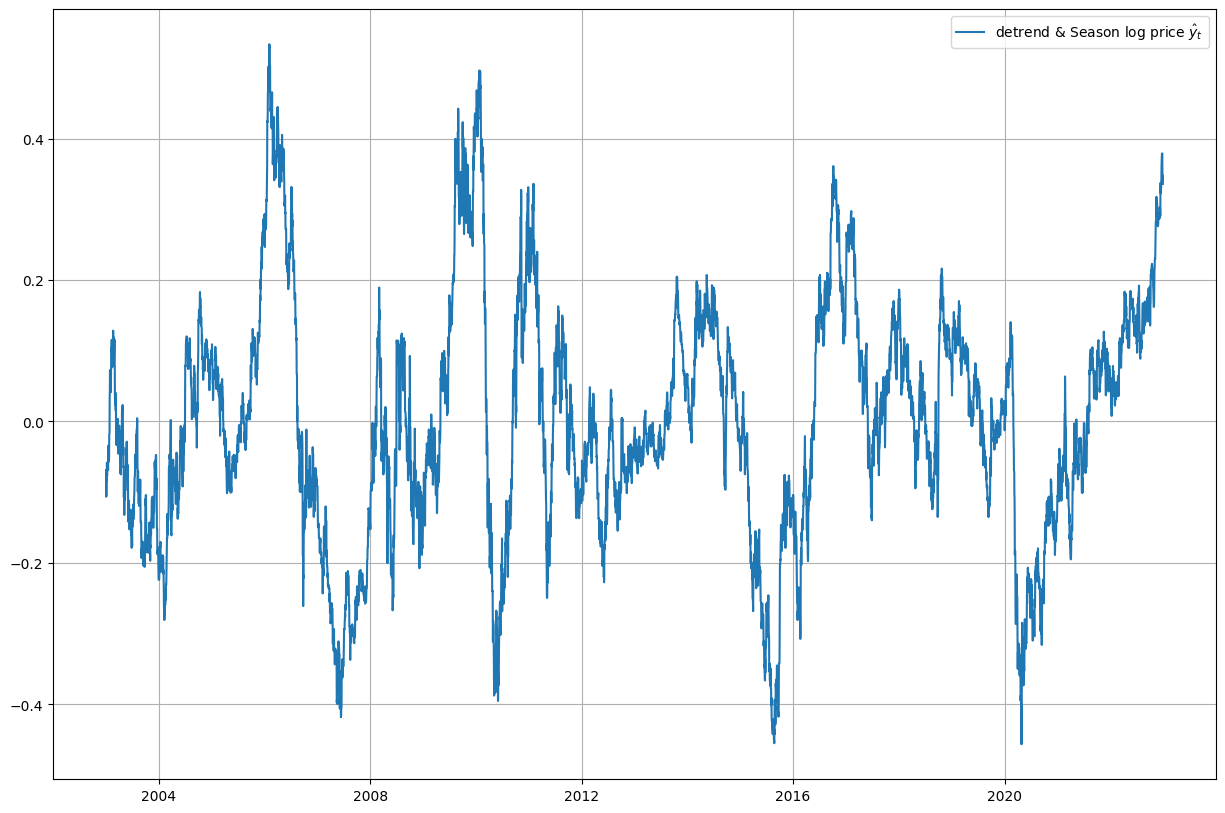

In [20]:
plt.figure(figsize=(15,10))
plt.plot(detrend - s, label=r"detrend & Season log price $\hat{y}_t$")
plt.legend()
plt.grid()

# Test for Stationary

## original Data

In [21]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(log_sugar_prices)
print('ADF statistic: ', result[0])
print('p-value: %.3f' % result[1])

critical_values = result[4]
for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

ADF statistic:  -2.2089976330381256
p-value: 0.203
Critical value (1%): -3.431
Critical value (5%): -2.862
Critical value (10%): -2.567


## Detrend

In [22]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(detrend)
print('ADF statistic: ', result[0])
print('p-value: %.3f' % result[1])

critical_values = result[4]
for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

ADF statistic:  -2.289057126219674
p-value: 0.176
Critical value (1%): -3.431
Critical value (5%): -2.862
Critical value (10%): -2.567


## Residue

In [23]:
from statsmodels.tsa.stattools import adfuller
resid = detrend - s
result = adfuller(resid )
print('ADF statistic: ', result[0])
print('p-value: %.3f' % result[1])

critical_values = result[4]
for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

ADF statistic:  -4.085729587288693
p-value: 0.001
Critical value (1%): -3.431
Critical value (5%): -2.862
Critical value (10%): -2.567


# Detrend by differencing

ADF statistic:  -37.87046297131117
p-value: 0.000
Critical value (1%): -3.431
Critical value (5%): -2.862
Critical value (10%): -2.567


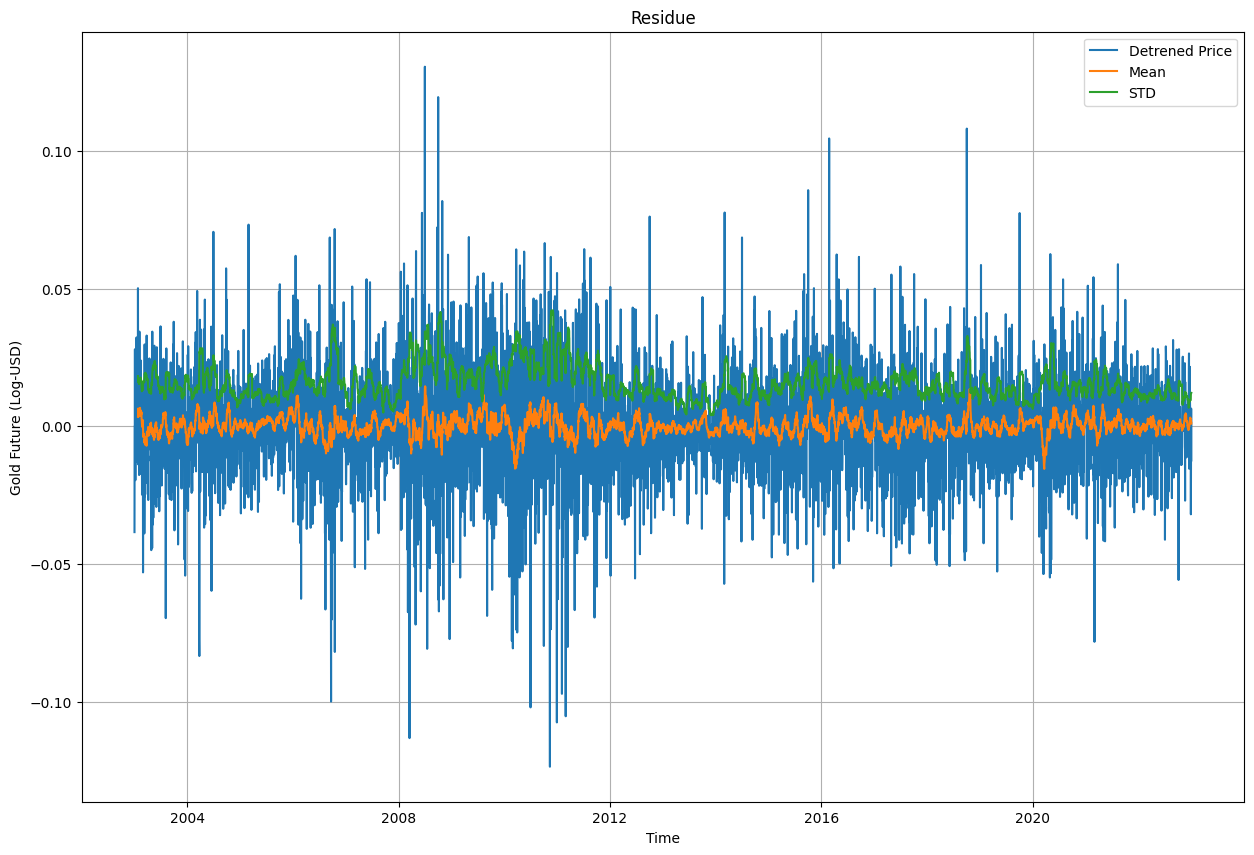

In [24]:
detrend_diff = log_sugar_prices.diff(1).dropna()
df_ma = detrend_diff.rolling(25).mean()
df_std = detrend_diff.rolling(25).std()
plt.figure(figsize=(15,10))
plt.plot(detrend_diff)
plt.plot(df_ma)
plt.plot(df_std)
plt.grid()
plt.title("Residue")
plt.xlabel("Time")
plt.ylabel("Gold Future (Log-USD)")
plt.legend(["Detrened Price", "Mean", "STD"])

result = adfuller(detrend_diff)
print('ADF statistic: ', result[0])
print('p-value: %.3f' % result[1])
critical_values = result[4]
for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

# detrend by moving average

ADF statistic:  -37.87046297131117
p-value: 0.000
Critical value (1%): -3.431
Critical value (5%): -2.862
Critical value (10%): -2.567


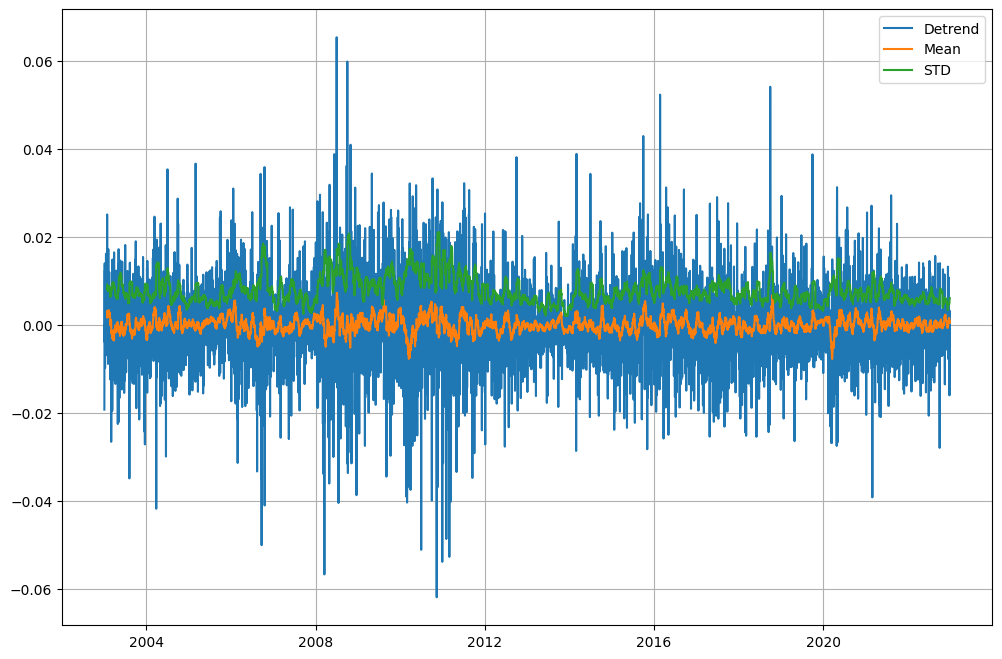

In [25]:
df_log_ma= log_sugar_prices.rolling(2).mean()
df_detrend = log_sugar_prices- df_log_ma
df_detrend.dropna(inplace=True)
# Mean and standard deviation of detrended data
df_detrend_rolling = df_detrend.rolling(25)
df_detrend_ma = df_detrend_rolling.mean()
df_detrend_std = df_detrend_rolling.std()

# Plot
plt.figure(figsize=(12, 8))
plt.plot(df_detrend)
plt.plot(df_detrend_ma)
plt.plot(df_detrend_std)
plt.grid()
plt.legend(['Detrend', 'Mean', 'STD']);

result = adfuller(detrend_diff)
print('ADF statistic: ', result[0])
print('p-value: %.3f' % result[1])
critical_values = result[4]
for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

# Seasonal Decompose module

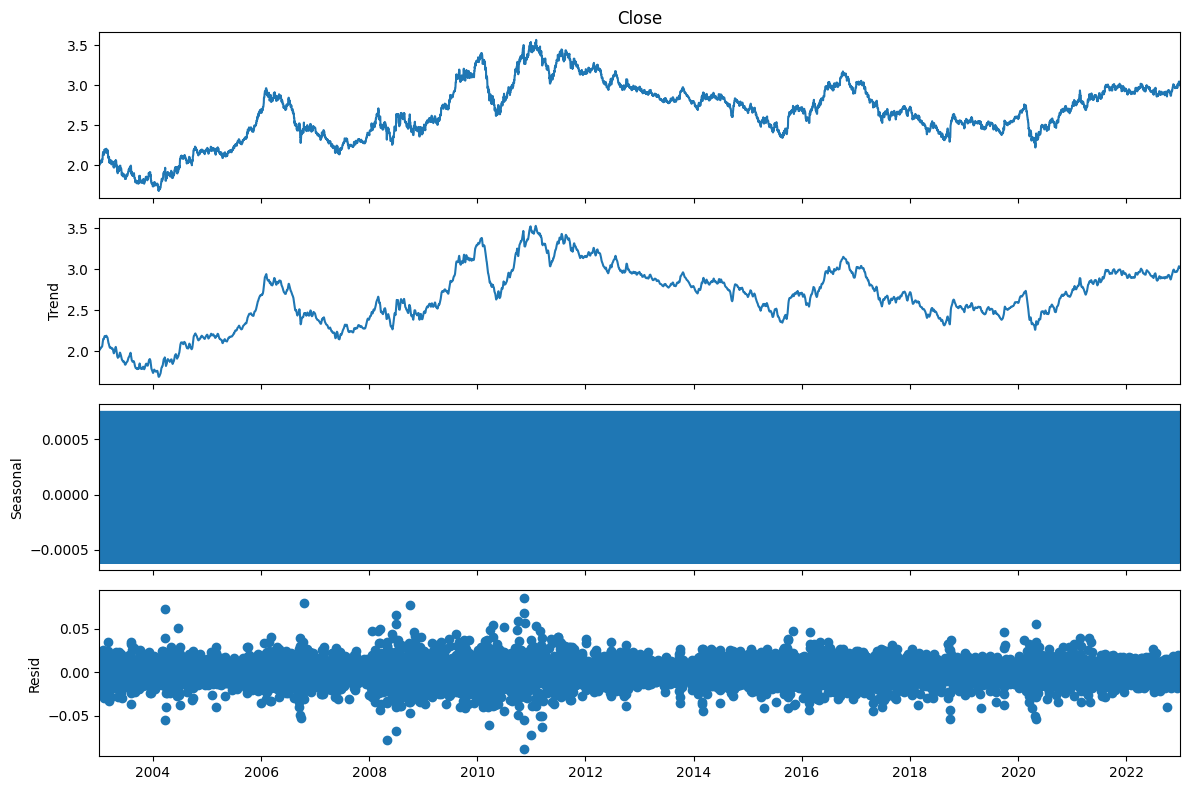

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(log_sugar_prices)
df_trend = decompose_result.trend
df_season = decompose_result.seasonal
df_residual = decompose_result.resid
plt.rcParams["figure.figsize"] = (12, 8)
fig = decompose_result.plot()


#ARMA model

## AR(1)

In [27]:
eurusd = yf.download(f"EURUSD=X", "2012-01-01", "2022-12-31").Close
eurusd = eurusd.resample('24h').ffill()
log_eurusd = np.log(eurusd)
eurusd.head()


[*********************100%%**********************]  1 of 1 completed


Date
2012-01-02    1.296008
2012-01-03    1.294096
2012-01-04    1.305602
2012-01-05    1.293142
2012-01-06    1.279607
Freq: 24H, Name: Close, dtype: float64

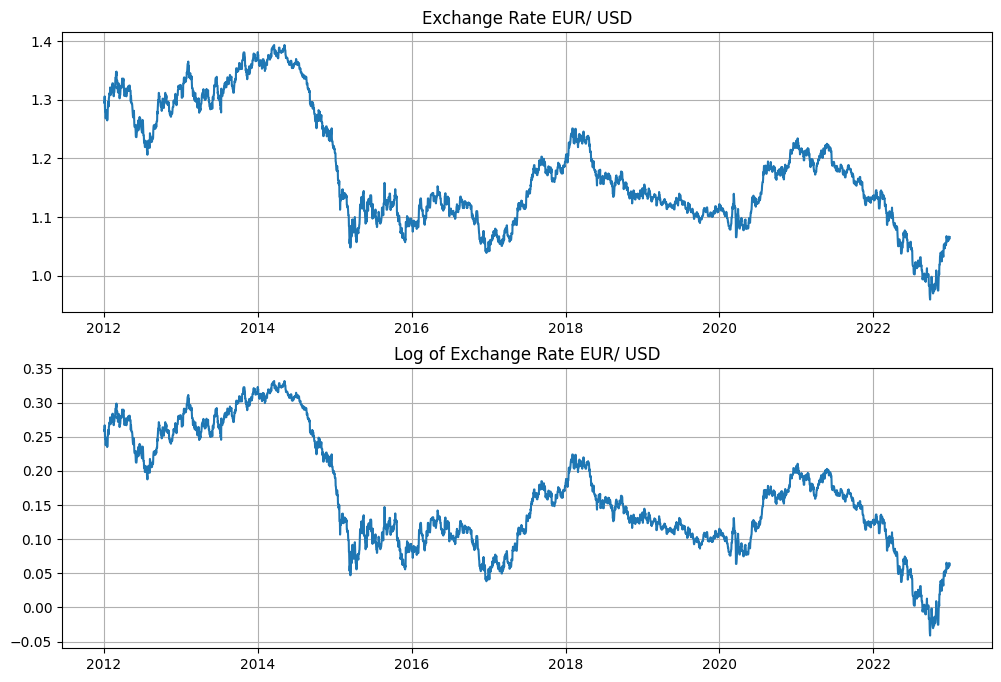

In [28]:
plt.subplot(2,1,1)
plt.plot(eurusd)
plt.title("Exchange Rate EUR/ USD")
plt.grid()
plt.subplot(2,1,2)
plt.plot(log_eurusd)
plt.title("Log of Exchange Rate EUR/ USD")
plt.grid()

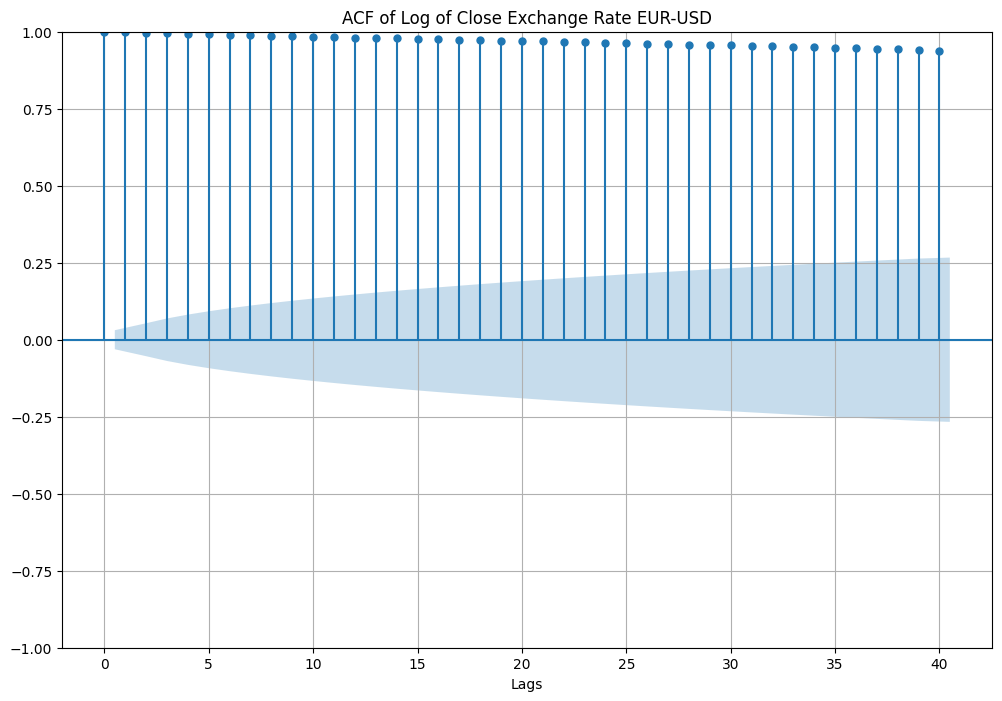

In [29]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(log_eurusd, lags=40)
plt.title("ACF of Log of Close Exchange Rate EUR-USD")
plt.xlabel("Lags")
plt.grid()


In [30]:
def cost(alpha, target, N=40):
  lags = np.arange(1, N+1)
  rho_hat = alpha ** lags
  error = ((rho_hat - target) ** 2).mean()
  return error


In [31]:
from statsmodels.tsa.stattools import acf
from scipy.optimize import minimize #optimization tool
target = acf(log_eurusd,nlags=40) #target ACF rho(h)
phi0 = 0.5 #initial phi = 0.5
res = minimize(cost, phi0, args=(target[1:], 40))
# minimize Cost function with x0=alpha0
phi_opt = res['x'][0] #optimum parameter
print(f"Optimum phi ={phi_opt}")

Optimum phi =0.9984564886839472


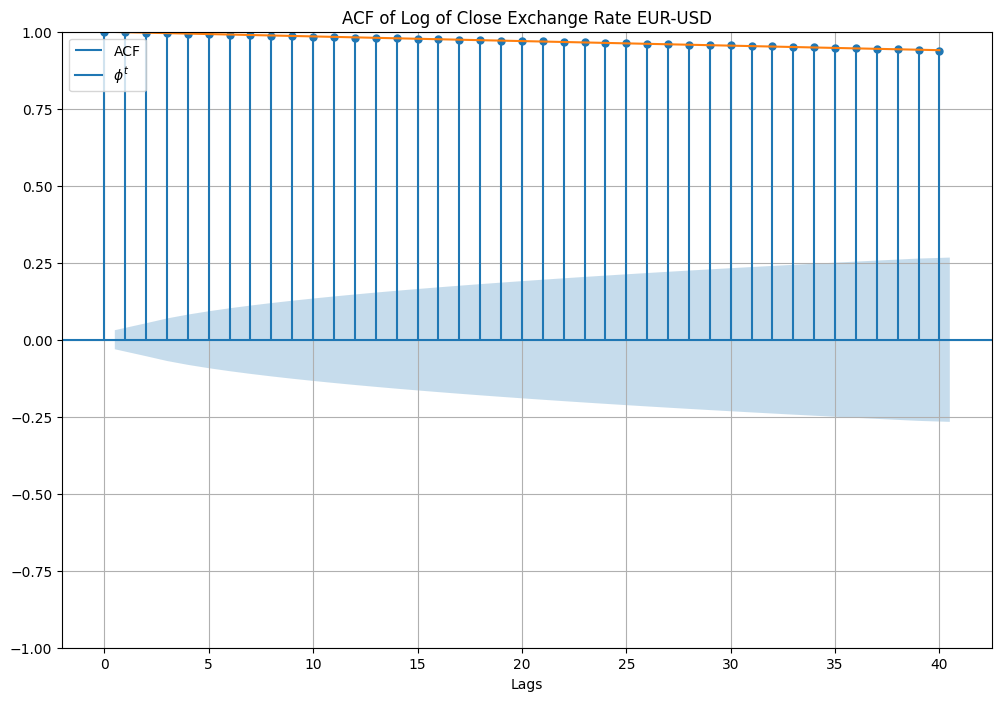

In [32]:
sm.graphics.tsa.plot_acf(log_eurusd, lags=40)
plt.title("ACF of Log of Close Exchange Rate EUR-USD")
plt.xlabel("Lags")
t = np.linspace(0,40,1000)
plt.plot(t, phi_opt ** t)
plt.legend(["ACF",r"$\phi^t$"])
plt.grid()



# Forecast using AR(1)

## Data Preparation

In [33]:
eurusd_2023 = yf.download(f"EURUSD=X", "2023-01-01", "2023-01-31").Close
eurusd_2023 = eurusd_2023.resample('24h').ffill()
log_eurusd_2023 = np.log(eurusd_2023)
close = log_eurusd_2023
print(close.head(2))
print(close.tail(2))



[*********************100%%**********************]  1 of 1 completed

Date
2023-01-02    0.068568
2023-01-03    0.065574
Freq: 24H, Name: Close, dtype: float64
Date
2023-01-29    0.085667
2023-01-30    0.083556
Freq: 24H, Name: Close, dtype: float64


## Detrend data

In [34]:
mean = close.mean()
xt = close - mean # detrend


In [35]:
predict_prices = []
for date in xt.index:
  x_t_hat = phi_opt * xt[date]
  x_t_hat += mean # add trend back
  predict_prices.append(x_t_hat)

In [36]:
predict_prices = pd.Series(data=predict_prices[:-1], index=xt.index[1:])


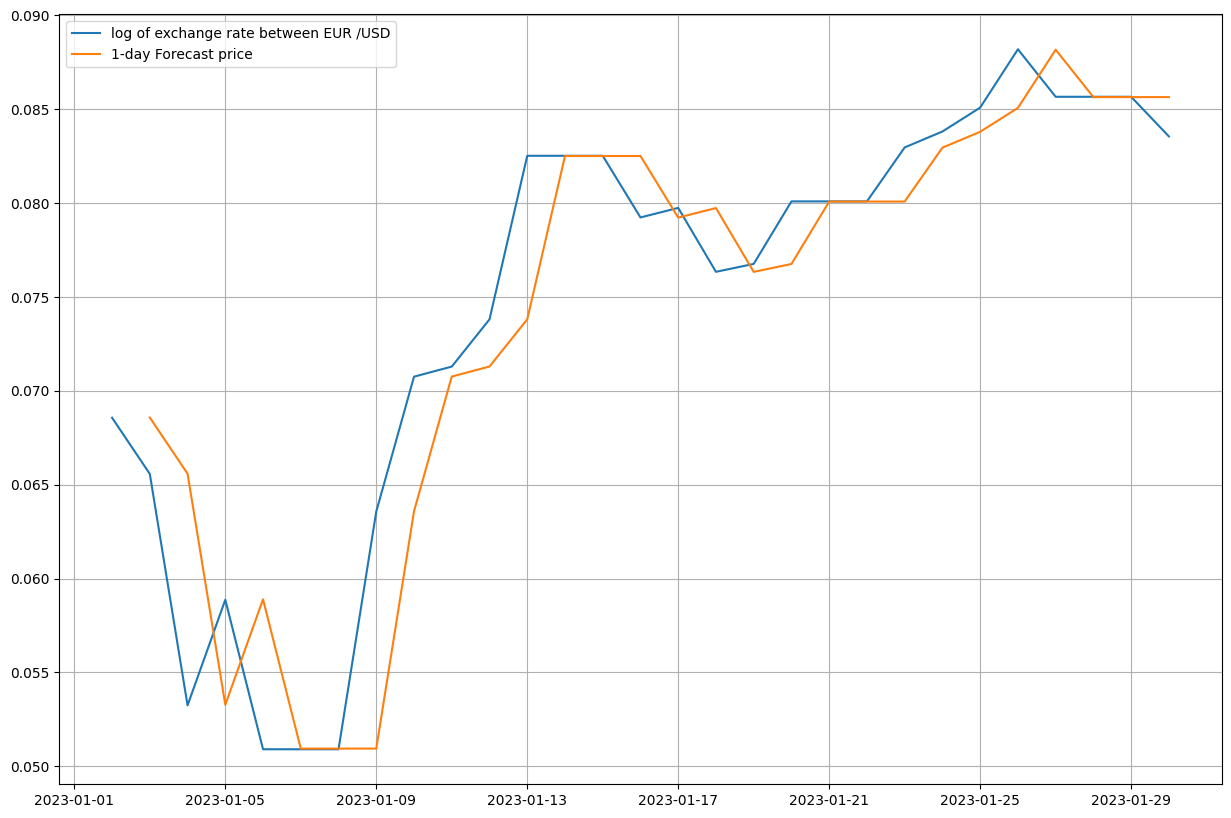

In [37]:
plt.figure(figsize=(15,10))
plt.plot(close, label="log of exchange rate between EUR /USD")
plt.plot(predict_prices , label="1-day Forecast price")
plt.legend()
plt.grid()

# Partial ACF

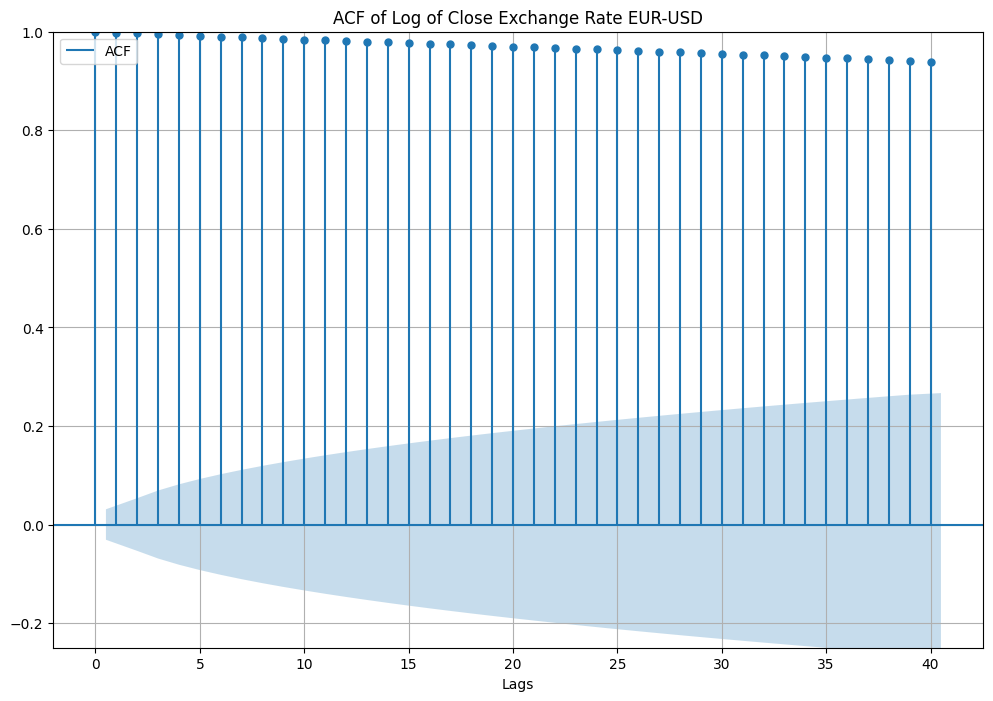

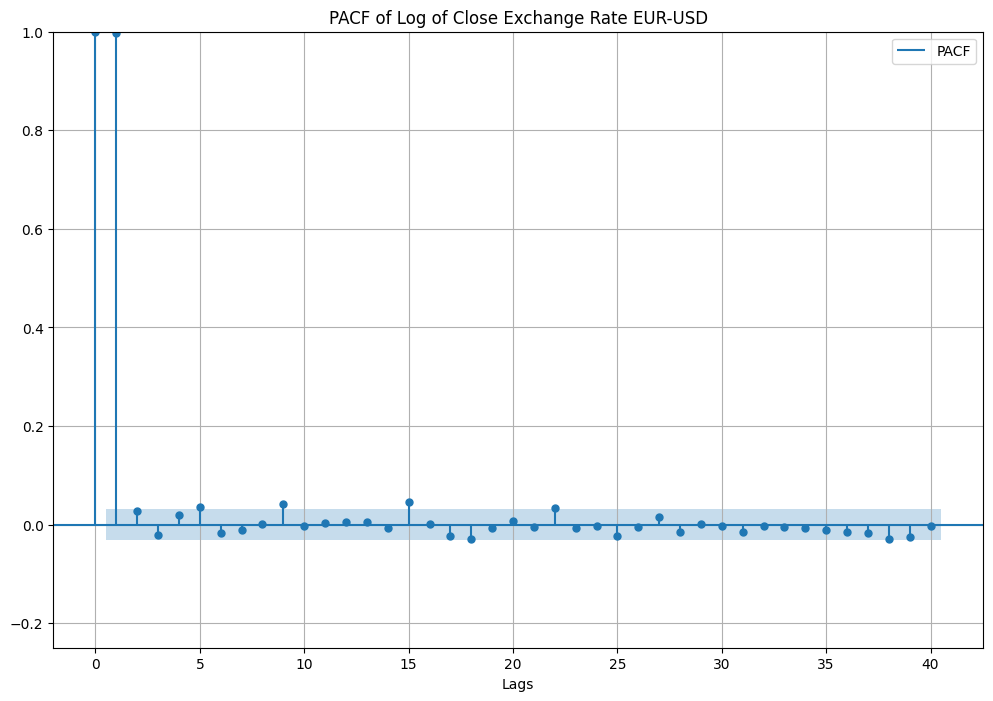

In [38]:
import statsmodels.api as sm
#plot
sm.graphics.tsa.plot_acf(log_eurusd, lags=40)
plt.title("ACF of Log of Close Exchange Rate EUR-USD")
plt.xlabel("Lags")
plt.legend(["ACF"])
plt.ylim([-0.25, 1.0])
plt.grid()
sm.graphics.tsa.plot_pacf(log_eurusd, lags=40)
plt.title("PACF of Log of Close Exchange Rate EUR-USD")
plt.xlabel("Lags")
plt.legend(["PACF"])
plt.ylim([-0.25, 1.0])
plt.grid()



# arima module

In [39]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(endog=log_eurusd, lags=[1], trend="c")
ar1_result = model.fit()
print(ar1_result.summary())


                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 4016
Model:                     AutoReg(1)   Log Likelihood               16197.610
Method:               Conditional MLE   S.D. of innovations              0.004
Date:                Wed, 24 Jan 2024   AIC                         -32389.220
Time:                        05:22:05   BIC                         -32370.327
Sample:                    01-03-2012   HQIC                        -32382.524
                         - 12-30-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.164      0.245      -0.000       0.000
Close.L1       0.9986      0.001   1204.601      0.000       0.997       1.000
                                    Roots           

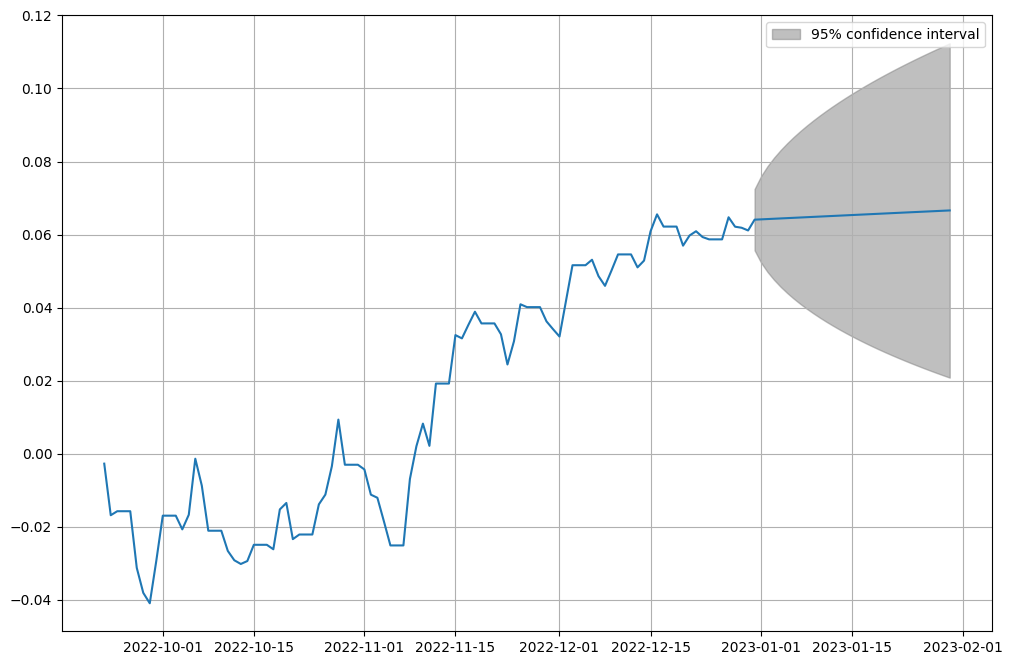

In [40]:
num_data = len(log_eurusd)
ar1_result.plot_predict(start=num_data-100, end=num_data+30)
plt.grid()


In [44]:
eurusd_2023 = yf.download(f"EURUSD=X", "2023-01-01", "2023-01-31").Close # get Jan 2023
eurusd_2023 = eurusd_2023.resample('24h').ffill() # fill missing values
num_data = len(log_eurusd)  # number of training data
dat0 = log_eurusd.index[-1] # last day in the training data
dat1 = eurusd_2023.index[-1] # last day of test data
addition_days = (dat1-dat0).days # additional days to forecast
predictor = ar1_result.get_prediction(start=num_data, end=num_data+addition_days )
# build predictor
log_forecast = predictor.predicted_mean  # mean forecast
log_confidence_int = predictor.conf_int(alpha=0.95) # confidence interval
forecast = np.exp(log_forecast) # convert back to real exchange rate
confidence_int = np.exp(log_confidence_int )
confidence_int.head()

[*********************100%%**********************]  1 of 1 completed


,lower,upper
2022-12-31,1.065881,1.066453
2023-01-01,1.065854,1.066664
2023-01-02,1.065855,1.066846
2023-01-03,1.065870,1.067014
2023-01-04,1.065895,1.067172


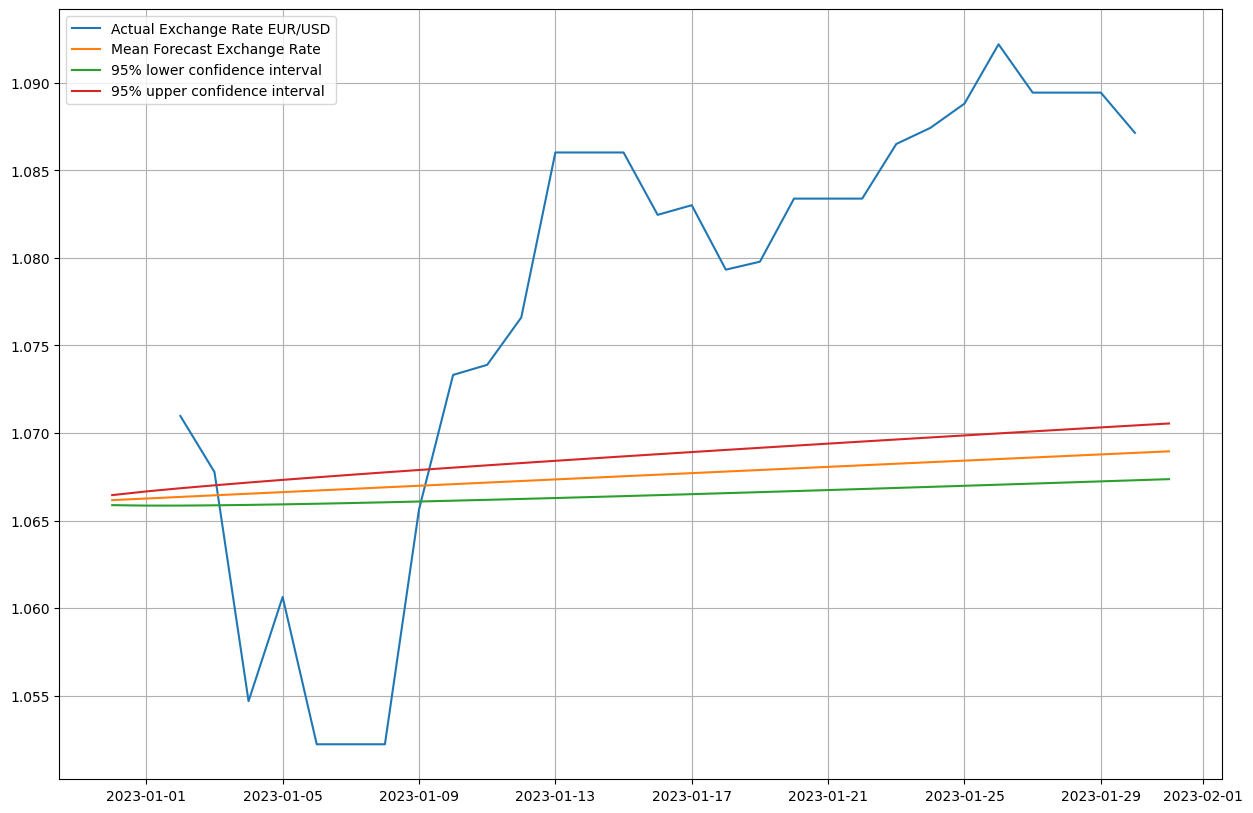

In [45]:
plt.figure(figsize=(15,10))
plt.plot(eurusd_2023, label="Actual Exchange Rate EUR/USD")
plt.plot(forecast, label="Mean Forecast Exchange Rate")
plt.plot(confidence_int['lower'], label="95% lower confidence interval")
plt.plot(confidence_int['upper'], label="95% upper confidence interval")
plt.legend()
plt.grid()

In [46]:
plt.plot(result.resid)
plt.grid()
plt.title("Residue Error")
print(f"RMSE: {np.sqrt((result.resid**2).mean())}")

AttributeError: 'tuple' object has no attribute 'resid'

Text(0, 0.5, '$\\rho(h)$')

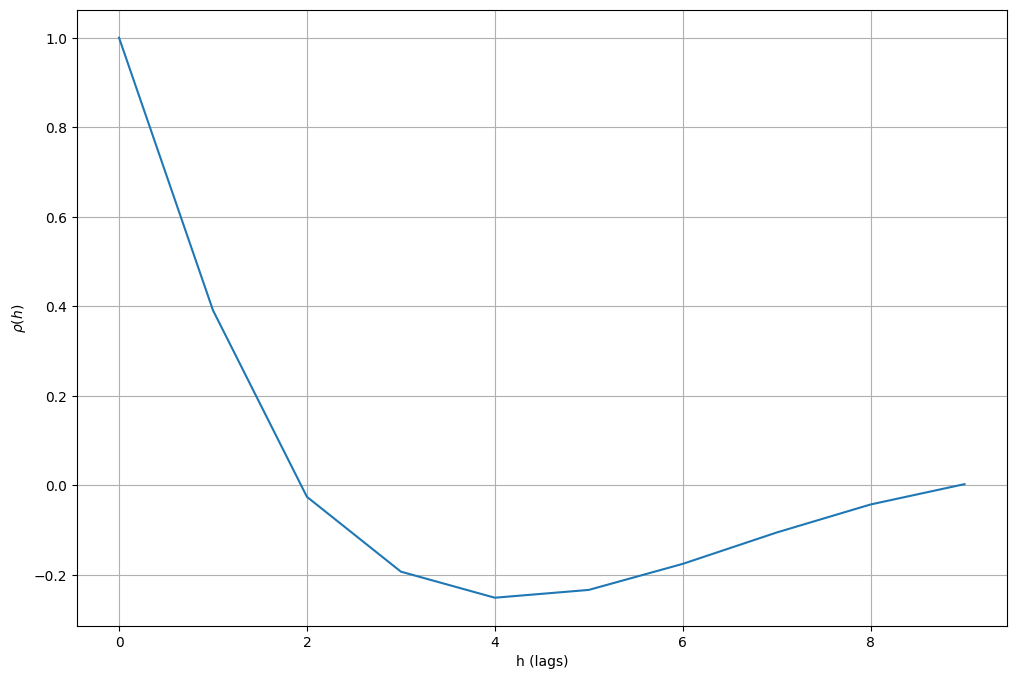

In [47]:
from statsmodels.tsa.arima_process import arma_acf
rho = arma_acf(ar=[1, -1.38,0.5854], ma =[1, -1.098, 0, 0.1053], lags = 10)
plt.plot(rho)
plt.grid()
plt.xlabel("h (lags)")
plt.ylabel(r"$\rho(h)$")


In [48]:
import itertools    # for looping over all possible p and q
import warnings # disable warning
import statsmodels.tsa.arima.model as arima_model # main arma model
warnings.simplefilter("ignore") # ignorall warning

def armaParameterSearch(data:pd.Series,
                        ar_order:int,
                        ma_order:int): #
  p = range(ar_order + 1) # 0,..., ar_oder
  q = range(ma_order + 1) # 0, ... , ma_order
  parameter_spaces = list(itertools.product(p,q)) # pairs of all possible values
  best_aic, pq, best_result = None, None, None # initilize to None
  for (p,  q) in parameter_spaces: # all p,q pairs
    try :
      model = arima_model.ARIMA(data, order=(p,0,q), trend="t") # Linear Trend
      result = model.fit() # fit with data
      if (best_aic is None) or (result.aic < best_aic):
        # if better aic
        best_aic = result.aic
        pq = (p,q)
        best_result = result
    except:
      continue
  return best_aic, pq, best_result


In [49]:
btc_eth = yf.download("BTC-USD", "2023-01-01", "2023-09-30").Close # BITCOIN/USD
log_btc_eth = np.log(btc_eth) # Change to log price
trend = log_btc_eth.rolling(25).mean() # detrend using moving average
detrend = log_btc_eth - trend
detrend = detrend.dropna()
best_aic, pq, best_arma_result = armaParameterSearch(detrend , ar_order=5, ma_order=5)
print(pq)



[*********************100%%**********************]  1 of 1 completed


(2, 2)


In [50]:
print(best_arma_result.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  248
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 597.009
Date:                Wed, 24 Jan 2024   AIC                          -1182.019
Time:                        05:23:57   BIC                          -1160.938
Sample:                    01-25-2023   HQIC                         -1173.532
                         - 09-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.323e-06      0.000      0.018      0.986      -0.000       0.000
ar.L1          1.6478      0.155     10.610      0.000       1.343       1.952
ar.L2         -0.6863      0.145     -4.730      0.0

[*********************100%%**********************]  1 of 1 completed


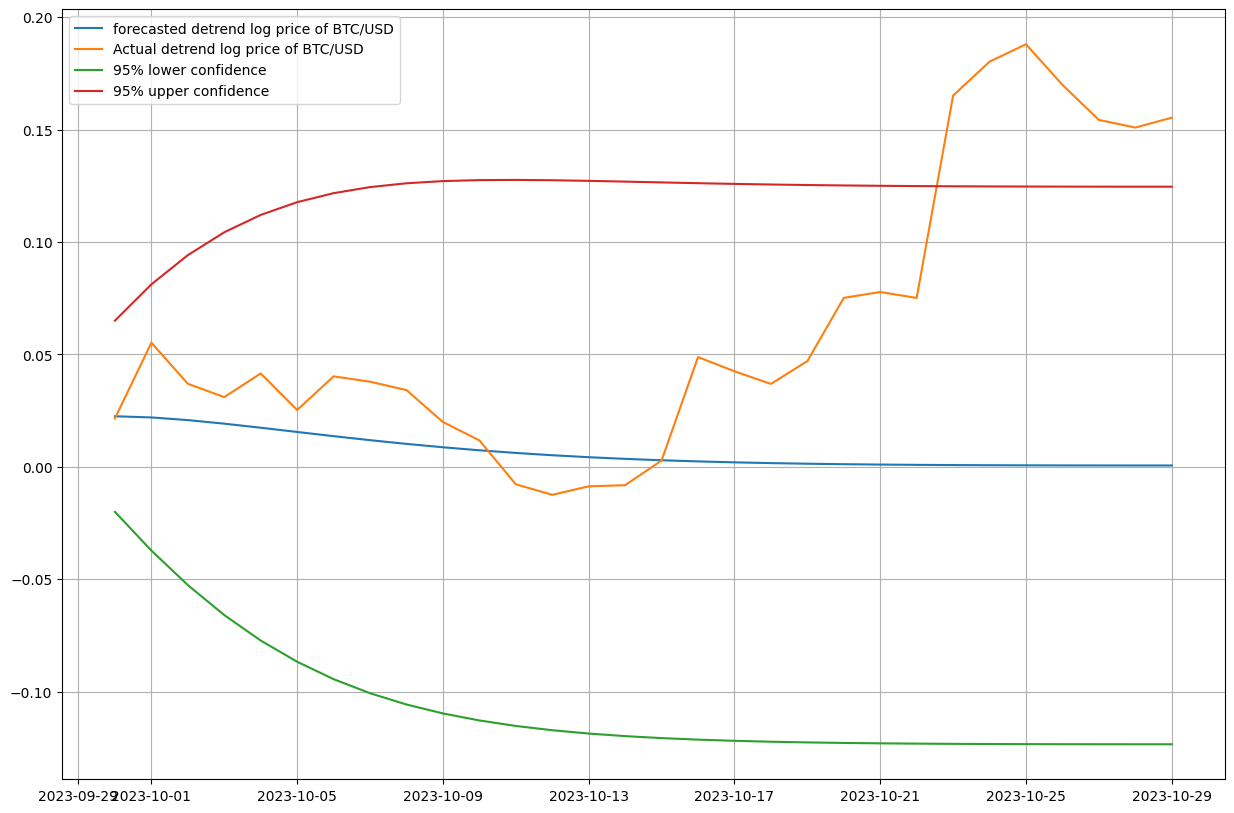

In [51]:
btc_eth2023 = yf.download("BTC-USD", "2023-01-01", "2023-12-31").Close # BITCOIN/USD
log_btc_eth2023 = np.log(btc_eth2023) # Change to log price
trend2023 = log_btc_eth2023.rolling(25).mean() # detrend using moving average
detrend2023 = log_btc_eth2023 - trend2023
forecast = best_arma_result.get_forecast(steps=30)
log_conf = forecast.conf_int()
log_lower_conf = log_conf["lower Close"]
log_upper_conf = log_conf["upper Close"]
log_price = forecast.predicted_mean
plt.figure(figsize=(15,10))
plt.plot(log_price, label="forecasted detrend log price of BTC/USD")
plt.plot(detrend2023[log_price.index], label="Actual detrend log price of BTC/USD")
plt.plot(log_lower_conf, label="95% lower confidence")
plt.plot(log_upper_conf, label="95% upper confidence")
plt.legend()
plt.grid()

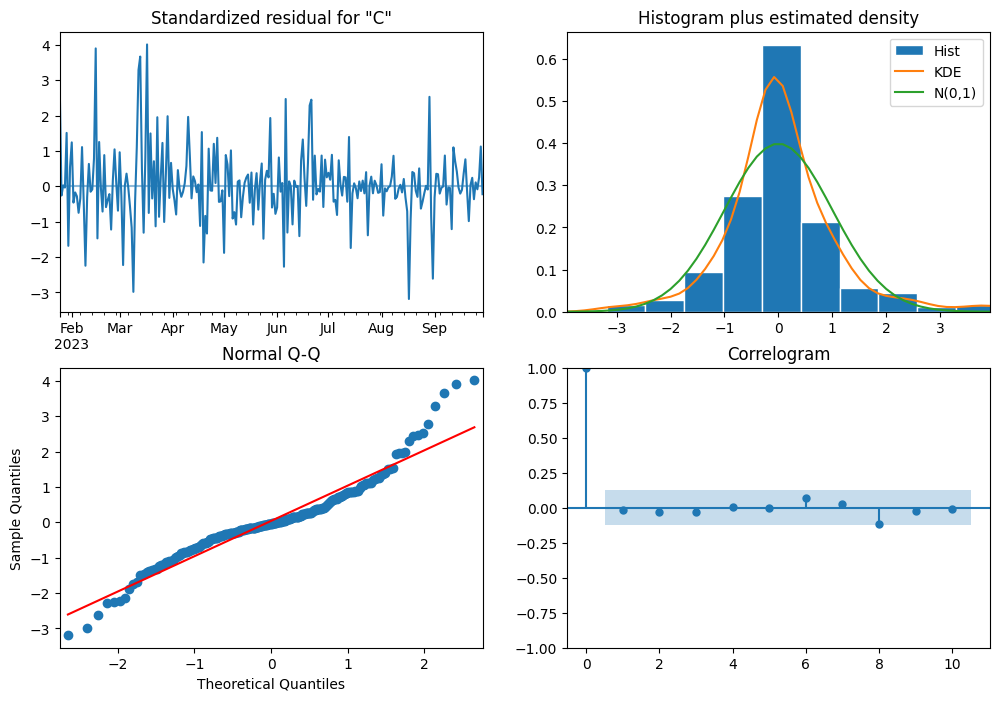

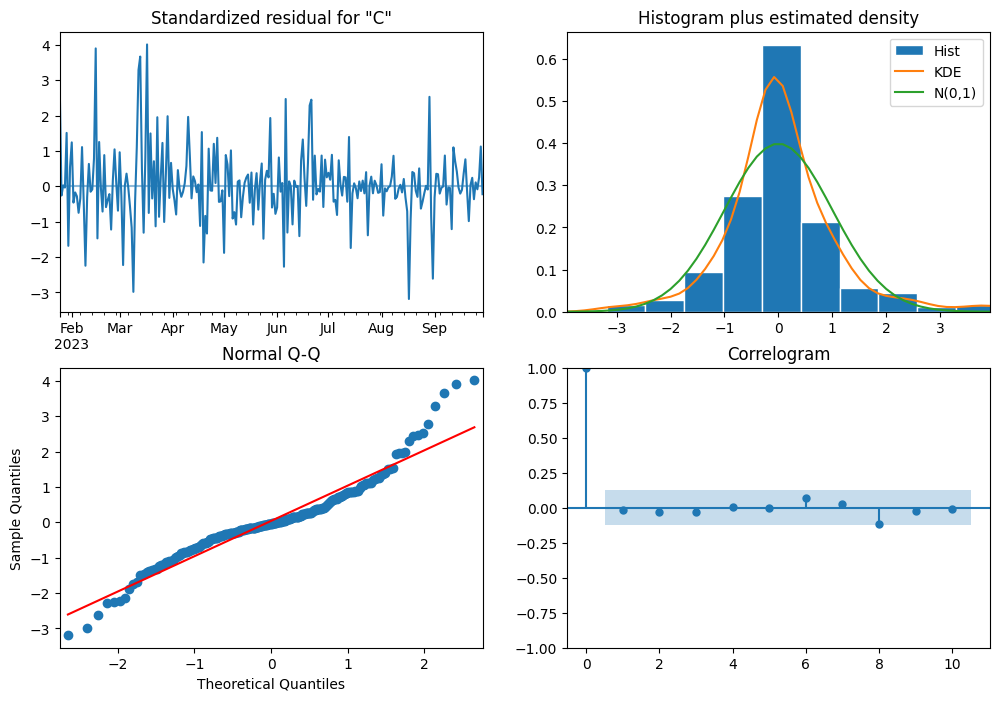

In [52]:
best_arma_result.plot_diagnostics()

# ARIMA Models

## Parameter search function

In [53]:
import itertools    # for looping over all possible p and q
import warnings # disable warning
import statsmodels.tsa.arima.model as arima_model # main arma model
warnings.simplefilter("ignore") # ignorall warning

def arimaParameterSearch(data:pd.Series,
                        ar_order:int,
                        ma_order:int,
                        d_order:int): #
  p = range(ar_order + 1) # 0,..., ar_oder
  q = range(ma_order + 1) # 0, ... , ma_orderd
  d = range(d_order + 1) # 0, ..., d_order
  parameter_spaces = list(itertools.product(p,d, q)) # pairs of all possible values
  best_aic, pdq, best_result = None, None, None # initilize to None
  for (p,  d, q) in parameter_spaces: # all p,q pairs
    try :
      model = arima_model.ARIMA(data, order=(p,d,q), trend="t") # Linear Trend
      result = model.fit() # fit with data
      if (best_aic is None) or (result.aic < best_aic):
        # if better aic
        best_aic = result.aic
        pdq = (p,d,q)
        best_result = result
    except:
      print(f"Cannot fit the model for p = {p}, d ={d} and q = {q}")
      continue
  return best_aic, pdq, best_result


### Examples
We do not need to detrend here since Integrating term (d) can take care of the trend

In [54]:
gold_price = yf.download("GC=F", "2023-01-01", "2023-10-01").Close # Gold Future
gold_price = gold_price.resample("1d").ffill()
best_aic, pdq, best_arima_result = arimaParameterSearch(gold_price,
                                                        ar_order=7,
                                                        ma_order=7,
                                                        d_order=1)
print(pdq)

best_aic, pq, best_arma_result = armaParameterSearch(gold_price,
                                                     ar_order=7,
                                                     ma_order=7)
print(pq)

[*********************100%%**********************]  1 of 1 completed


(2, 1, 2)
(5, 1)


### Best ARIMA Model

In [55]:
print(best_arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  270
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1067.151
Date:                Wed, 24 Jan 2024   AIC                           2146.301
Time:                        05:28:09   BIC                           2167.870
Sample:                    01-03-2023   HQIC                          2154.963
                         - 09-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0772      0.833      0.093      0.926      -1.555       1.709
ar.L1         -1.3215      0.034    -39.049      0.000      -1.388      -1.255
ar.L2         -0.9285      0.030    -31.133      0.0

### Best ARMA Model

In [56]:
print(best_arma_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  270
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -1075.656
Date:                Wed, 24 Jan 2024   AIC                           2167.311
Time:                        05:28:09   BIC                           2196.099
Sample:                    01-03-2023   HQIC                          2178.871
                         - 09-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0659      0.782      0.084      0.933      -1.467       1.599
ar.L1         -0.0341      0.068     -0.504      0.614      -0.167       0.098
ar.L2          1.0144      0.067     15.122      0.0

[*********************100%%**********************]  1 of 1 completed


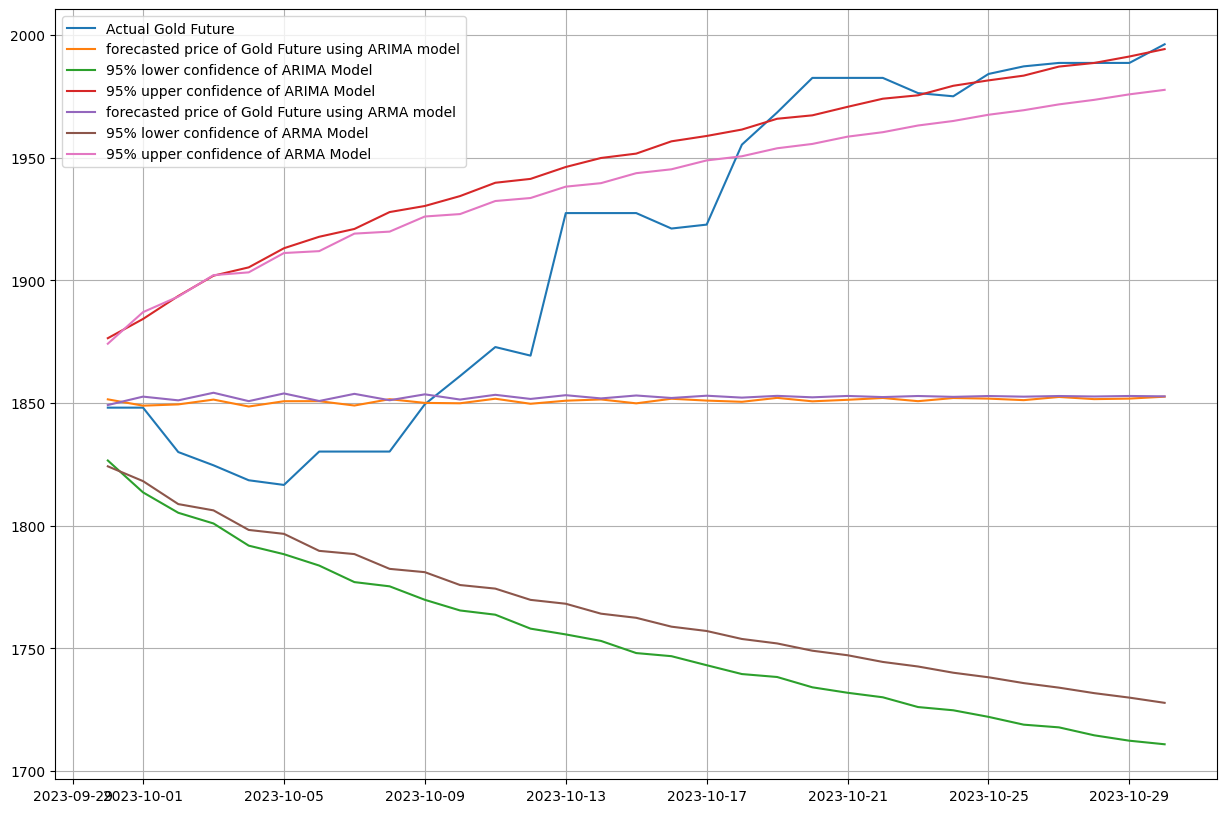

In [57]:
# load data
gold_2023 = yf.download("GC=F", "2023-01-01", "2023-12-31").Close # Gold Future
gold_2023 = gold_2023.resample("1d").ffill()
#ARIMA
forecast_arima = best_arima_result.get_forecast(steps=31)
conf = forecast_arima.conf_int()
lower_conf = conf["lower Close"]
upper_conf = conf["upper Close"]
forecasted_arima_price = forecast_arima.predicted_mean
plt.figure(figsize=(15,10))
plt.plot(gold_2023[forecasted_arima_price.index], label="Actual Gold Future")
plt.plot(forecasted_arima_price, label="forecasted price of Gold Future using ARIMA model")
plt.plot(lower_conf, label="95% lower confidence of ARIMA Model")
plt.plot(upper_conf, label="95% upper confidence of ARIMA Model")
# ARMA
forecast_arma = best_arma_result.get_forecast(steps=31)
conf = forecast_arma.conf_int()
lower_conf = conf["lower Close"]
upper_conf = conf["upper Close"]
forecasted_arma_price = forecast_arma.predicted_mean
plt.plot(forecasted_arma_price, label="forecasted price of Gold Future using ARMA model")
plt.plot(lower_conf, label="95% lower confidence of ARMA Model")
plt.plot(upper_conf, label="95% upper confidence of ARMA Model")
plt.legend()
plt.grid()

# SARIMA

In [58]:
reveune = pd.read_excel("/content/amazonRevenue.xlsx")
reveune = reveune.set_index("Date")
reveune.head()

,Value
Date,
2011-06-30,9.913
2011-09-30,10.880
2011-12-31,17.430
2012-03-31,13.180
2012-06-30,12.830


## Plot the Amazon Revenue

Text(0.5, 1.0, 'Log of Amazon Revenue')

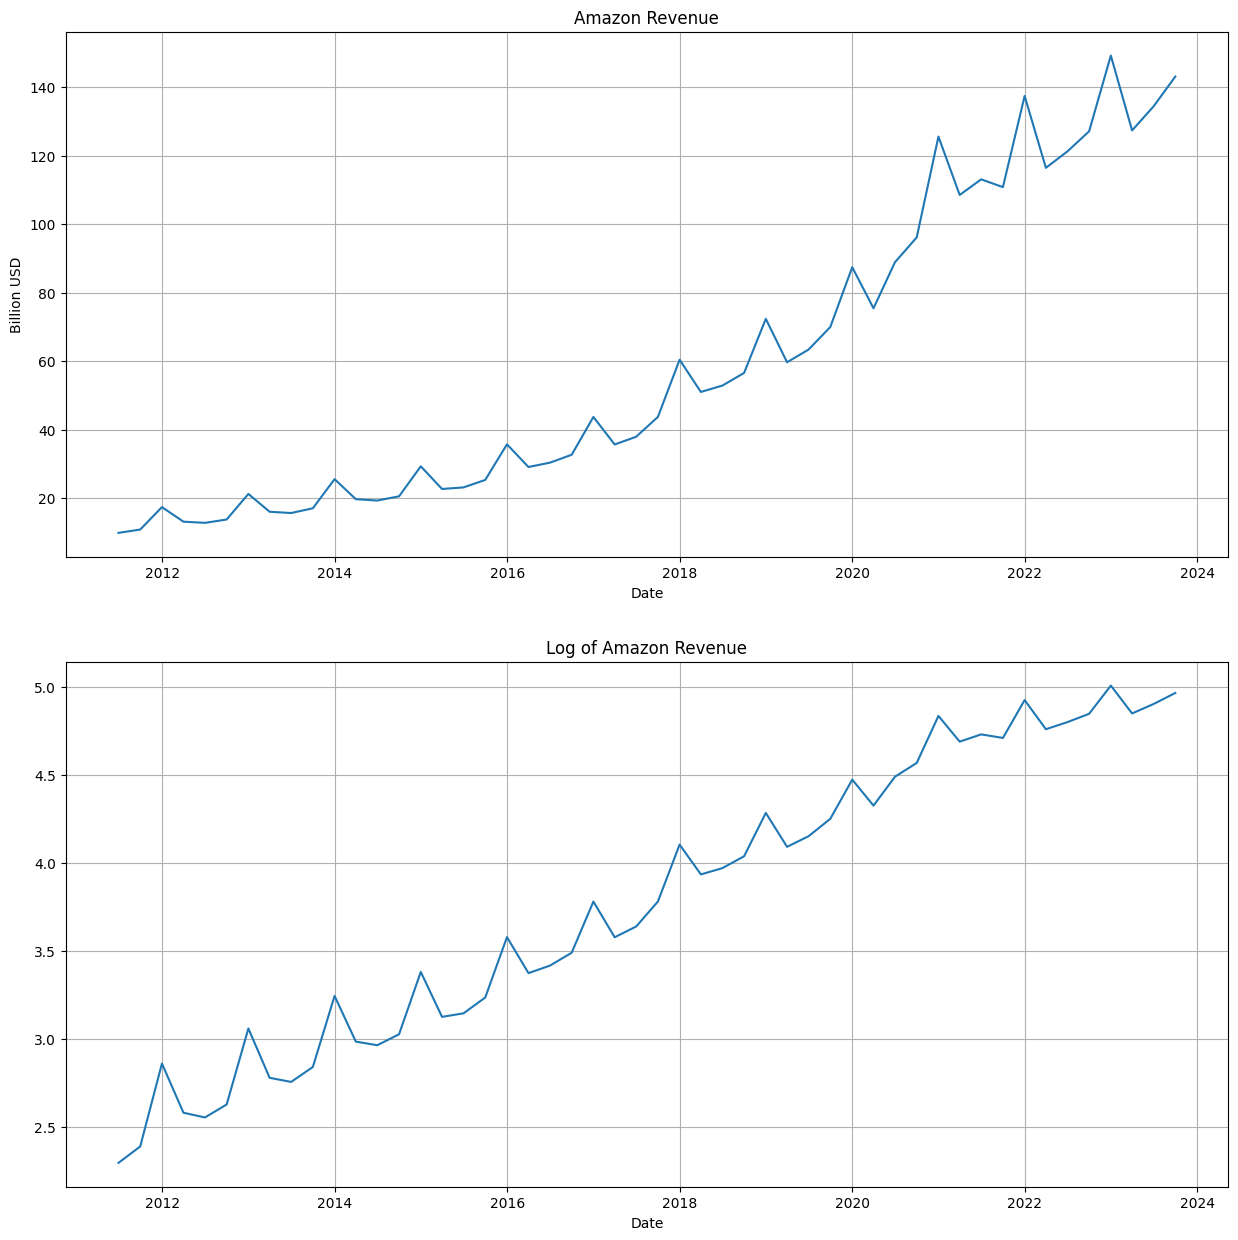

In [59]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(reveune)
plt.grid()
plt.xlabel("Date")
plt.ylabel("Billion USD")
plt.title("Amazon Revenue")
plt.subplot(2,1,2)
plt.plot(np.log(reveune))
plt.grid()
plt.xlabel("Date")
plt.title("Log of Amazon Revenue")

It is obvious from the plot that the data have a strong trend. Thus, the trend of the log-revenue will be removed using differencing

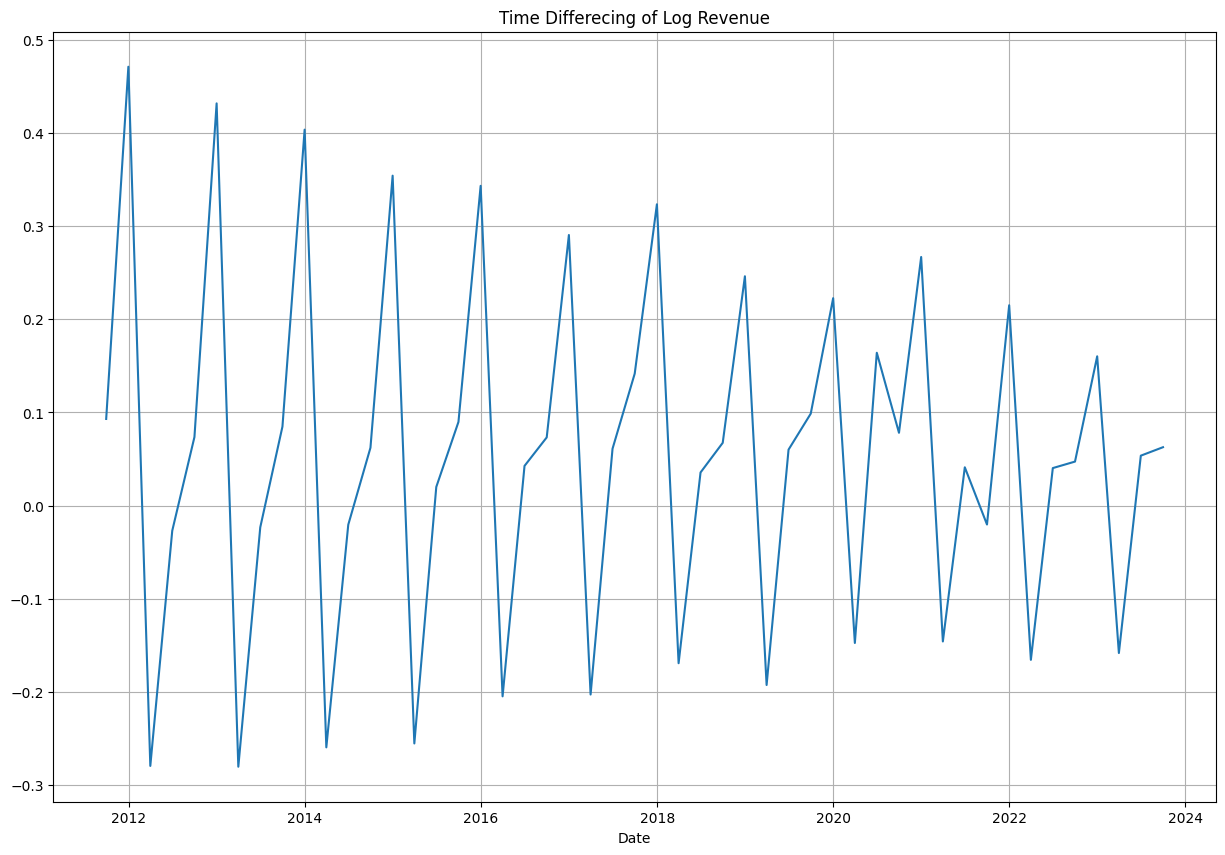

In [60]:
detrend_log_revenue = np.log(reveune).diff(1).dropna() # log p_t - log p_t-1
plt.figure(figsize=(15,10))
plt.plot(detrend_log_revenue)
plt.xlabel("Date")
plt.title("Time Differecing of Log Revenue")
plt.grid()

## Detrend log-price seems to have a strong seasonaility

To check for a strong seasonality, we compute the auto-correlation and partial auto-correlation function

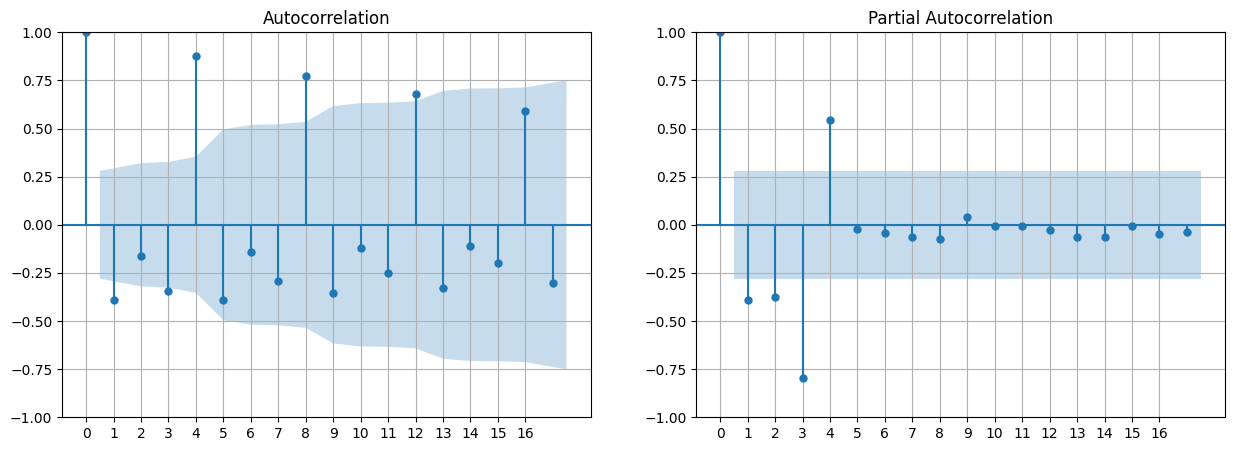

In [61]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes  = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
f1 = plot_acf(detrend_log_revenue, ax=axes[0])
f2 = plot_pacf(detrend_log_revenue, ax=axes[1])
axes[0].set_xticks(np.arange(17))
axes[0].grid()
axes[1].set_xticks(np.arange(17))
axes[1].grid()

We observe that ACF seems to repeat every 4 quarters (samples) and PACF disappears after 4 quarters as well.
Thus, the seasonal term has a period of 4 quarters.

In [62]:
import itertools    # for looping over all possible p and q
import warnings # disable warning

from  statsmodels.tsa.statespace.sarimax import SARIMAX # main sarimax model
warnings.simplefilter("ignore") # ignorall warning

def sarimaParameterSearch(data:pd.Series,
                          s:int,
                          ar_order:int,
                          ma_order:int,
                          d_order:int,
                          ar_s_order:int,
                          ma_s_order:int,
                          d_s_order:int):
  p = range(ar_order + 1) # 0,..., ar_oder
  q = range(ma_order + 1) # 0, ... , ma_orderd
  d = range(d_order + 1) # 0, ..., d_order
  P = range(ar_s_order + 1) # 0,..., ar_oder
  Q = range(ma_s_order + 1) # 0, ... , ma_orderd
  D = range(d_s_order + 1) # 0, ..., d_order
  parameter_arima_spaces = list(itertools.product(p,d, q)) # pairs of all possible values
  parameter_season_spaces = list(itertools.product(P,D, Q)) # pairs of all possible values
  best_aic, pdq, PDQS, best_result = None, None, None, None # initilize to None
  for (P, D, Q) in parameter_season_spaces:
    for (p,  d, q) in parameter_arima_spaces: # all p,q pairs
      try :
        model = SARIMAX(endog=data, order=(p,d,q), seasonal_order=(P, D,Q, s))
        result = model.fit() # fit with data
        if (best_aic is None) or (result.aic < best_aic):
          # if better aic
          best_aic = result.aic
          pdq = (p,d,q)
          PDQS = (P,D,Q,s)
          best_result = result
      except:
        print(f"Cannot fit the model for p = {p}, d ={d} and q = {q} and P = {P}, D ={P} and Q = {Q}")
        continue
  return best_aic, pdq, PDQS, best_result


Divide data into Train and Validation

In [63]:
train = detrend_log_revenue[:"2020"]
test = detrend_log_revenue["2021":]
train.tail(), test.head()

(               Value
 Date                
 2020-01-01  0.222743
 2020-03-31 -0.147483
 2020-06-30  0.164154
 2020-09-30  0.078181
 2020-12-31  0.266978,
                Value
 Date                
 2021-03-31 -0.145849
 2021-06-30  0.041161
 2021-09-30 -0.020279
 2021-12-31  0.215152
 2022-03-31 -0.165593)

In [64]:
best_aic,  pdq, PDQS, best_sarimax_result = sarimaParameterSearch(data=train,
                                                                  s=4,
                                                                  ar_order=2,
                                                                  ma_order=2,
                                                                  d_order=1,
                                                                  ar_s_order=3,
                                                                  ma_s_order=3,
                                                                  d_s_order=1)

In [65]:
print("best pdq: ", pdq)
print("best PDQS: ", PDQS)

best pdq:  (1, 0, 0)
best PDQS:  (2, 1, 1, 4)


In [66]:
best_sarimax_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Value   No. Observations:                   38
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 4)   Log Likelihood                  67.150
Date:                             Wed, 24 Jan 2024   AIC                           -124.300
Time:                                     05:33:51   BIC                           -116.668
Sample:                                          0   HQIC                          -121.697
                                              - 38                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3248      0.209      1.556      0.120      -0.084       0.734
ar.S.L4        0.4928      0.337      1.463      0.143      -0.167       1.153
ar.S.L8        0.4729      0.239      1.976      0.048       0.004       0.942
ma.S.L4       -0.8066      0.646     -1.249      0.212      -2.073       0.460
sigma2         0.0010      0.000      3.057      0.002       0.000       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.44
Prob(Q):                              0.96   Prob(JB):                         0.04
Heteroskedasticity (H):               5.38   Skew:                             0.96
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

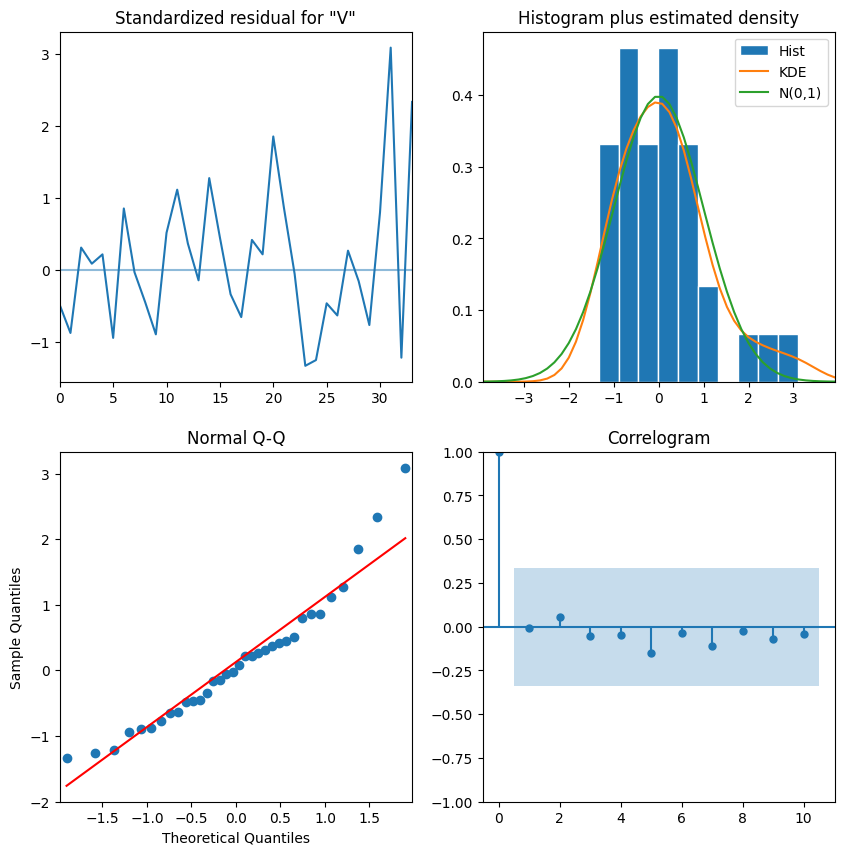

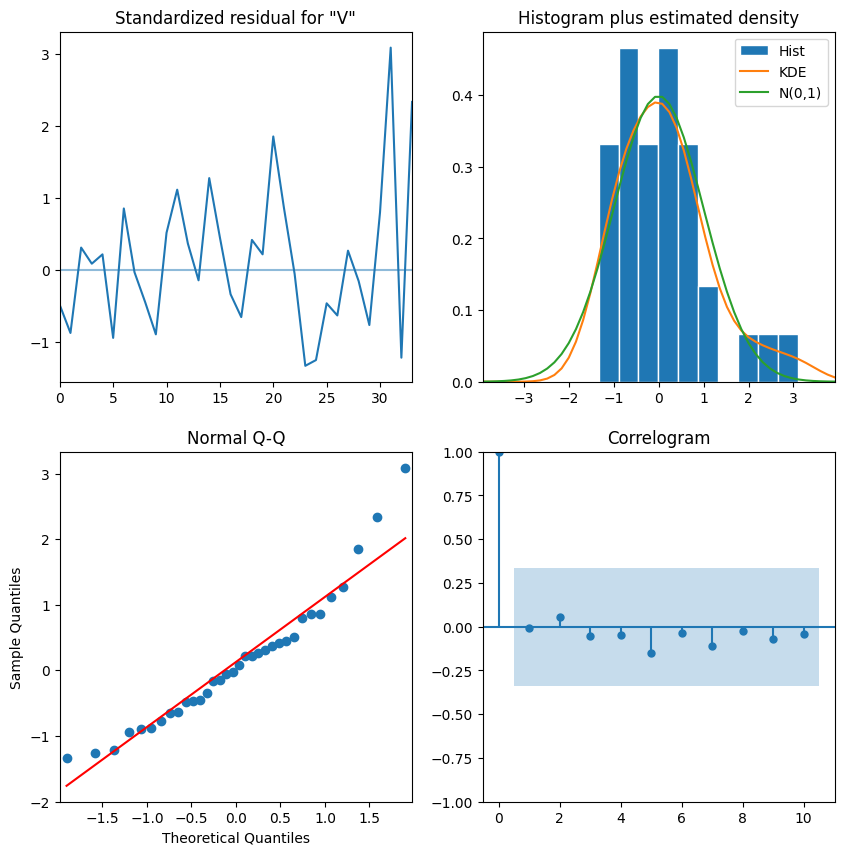

In [67]:
fig = plt.figure(figsize=(10,10))
best_sarimax_result.plot_diagnostics(fig=fig)

## Forecast using SARAMAX

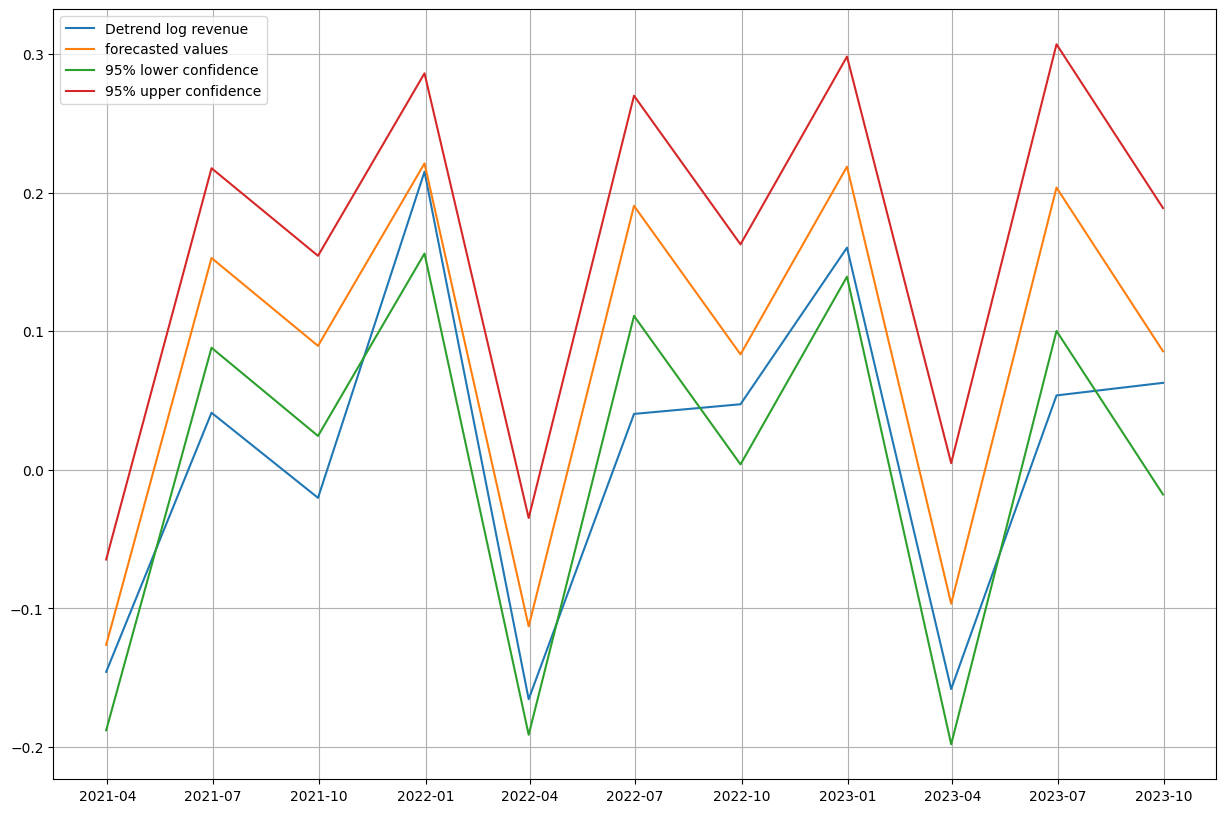

In [68]:
n_step = len(test)
forecast_sarimax = best_sarimax_result.get_forecast(steps=n_step)
conf = forecast_sarimax.conf_int()
lower_conf = conf["lower Value"]
upper_conf = conf["upper Value"]
forecasted_sarimax_price = forecast_sarimax.predicted_mean
plt.figure(figsize=(15,10))
forecasted_sarimax_price.index = test.index
lower_conf.index = test.index
upper_conf.index = test.index
plt.plot(test, label="Detrend log revenue")
plt.plot(forecasted_sarimax_price, label="forecasted values")
plt.plot(lower_conf, label="95% lower confidence")
plt.plot(upper_conf, label="95% upper confidence")
plt.legend()
plt.grid()